In [1]:
import os
import sys
import umap.umap_ as umap

import numpy as np
import pandas as pd
import seaborn as sns
import gseapy as gp

from lifelines import KaplanMeierFitter as KM
from lifelines import CoxPHFitter as cox
from matplotlib import pyplot as plt
from pandas import DataFrame as df
from scipy import stats
from IPython.display import Image
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import MinMaxScaler, StandardScaler

import matplotlib
import matplotlib.font_manager as fm
from matplotlib.ft2font import FT2Font
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

def get_font(*args, **kwargs):
    return FT2Font(*args, **kwargs)

fm.get_font = get_font

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [2]:
import gc
gc.collect()

476

# Global Path

In [3]:
poseidon_home = '/home/dyang-server/hdd/Yue/PROJECTS/POSEIDON/'
data_home = poseidon_home + 'data/'
gsea_home = poseidon_home + 'GSEA/'
result_home = poseidon_home + 'results/'
panel_home = poseidon_home + 'panels/Figure7/'
shift_home = poseidon_home + 'shift_ability/'

In [4]:
gene_sets = {}
with open(gsea_home + '/gene_sets/NREC_REC_91061.gmt', 'r') as f:
    for lines in f:
        lines = lines.rstrip().split('\t')
        gene_sets[lines[0]] = lines[2:]

# Data

In [5]:
# TEC signature infor
TEC_sig = pd.read_csv(poseidon_home + 'EC_signatures/all_NREC_REC_gene_info.csv',
                      index_col=0, header=0, sep=',')

In [6]:
# list of EC genes with both pharmacological and genetic inhibition available
bitarget_gene_info = pd.read_csv(poseidon_home + 'EC_signatures/sh_cp_available_NREC_REC_gene_info.csv',
                                 header=0, index_col=0, sep=',')

In [7]:
shRNA_cancer = ['BRCA', 'CRC', 'LIHC', 'LUNG', 'PRAD', 'SKCM']
compound_cancer = ['BLCA', 'BRCA', 'CESC', 'CRC', 'LIHC', 'LUNG',
                   'OV', 'PAAD', 'PRAD', 'SKCM', 'STAD', 'UCEC']


# read the shRNA enrichment results
shRNA_result = {}
for ct in shRNA_cancer:
    shRNA_result[ct] = pd.read_csv(shift_home + ct + '_trt_sh.csv',
                                   sep=',', index_col=0)
    shRNA_result[ct]['cancer_type'] = ct
    print(ct, shRNA_result[ct].shape)
    
# read the compound enrichment results
compound_result = {}
for ct in compound_cancer:
    compound_result[ct] = pd.read_csv(shift_home + ct + '_trt_cp.csv',
                                   sep=',', index_col=0)
    compound_result[ct]['cancer_type'] = ct
    print(ct, compound_result[ct].shape)

BRCA (2060, 7)
CRC (1317, 7)
LIHC (1437, 7)
LUNG (2828, 7)
PRAD (3923, 7)
SKCM (2384, 7)
BLCA (5, 7)
BRCA (9573, 7)
CESC (2906, 7)
CRC (4516, 7)
LIHC (2361, 7)
LUNG (6901, 7)
OV (53, 7)
PAAD (1906, 7)
PRAD (8107, 7)
SKCM (4917, 7)
STAD (38, 7)
UCEC (38, 7)


In [8]:
# merge the results into the matrix
merged_shRNA = pd.concat([shRNA_result[d] for d in shRNA_result.keys()], axis=0)
merged_compound = pd.concat([compound_result[d] for d in compound_result.keys()], axis=0)

In [279]:
merged_shRNA.shape

(13949, 8)

In [282]:
merged_shRNA['cmap_name'].unique().shape

(3488,)

In [283]:
merged_shRNA['cell_line'].unique().shape

(10,)

In [280]:
merged_compound.shape

(41321, 8)

In [16]:
sig_info = pd.read_csv(data_home + 'CMAP2020_Cancer/siginfo_beta.txt',
                            header=0, index_col='sig_id', sep='\t')
compound_info = pd.read_csv(data_home + '/CMAP2020_Cancer/compoundinfo_beta.txt',
                            header=0, index_col=1, sep='\t')
compound_info = compound_info.groupby(level=0).first()

/home/dyang-server/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (0,3,4,28,29) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [17]:
merged_shRNA['cell_line'] = sig_info['cell_iname']

In [18]:
merged_compound['cell_line'] = sig_info['cell_iname']

In [95]:
# op targets
op_target = list(set(merged_shRNA['cmap_name'].unique()) & set(compound_info['target'].unique()))

In [585]:
len(op_target)

300

# 0. Pre-filtering: high shifting targets

In [98]:
# shRNA
sub_shRNA = merged_shRNA[merged_shRNA['cmap_name'].isin(op_target)]
sub_shRNA.shape

(1764, 8)

In [99]:
sub_shRNA[sub_shRNA['cmap_name'] == 'PAK4']

,NREC_profile,REC_profile,cmap_name,nearest_dose,pert_idose,shift_ability,cancer_type,cell_line
KDB004_HT29_96H:TRCN0000010198:-666,-0.300616,0.315164,PAK4,NaN,NaN,0.615780,CRC,HT29
KDA008_HEPG2_96H:TRCN0000272514:-666,-0.206436,0.228114,PAK4,NaN,NaN,0.434550,LIHC,HEPG2
KDB004_A549_96H:TRCN0000010200:-666,0.176231,0.256134,PAK4,NaN,NaN,0.079904,LUNG,A549
KDB004_A375_96H:TRCN0000010201:-666,-0.334421,0.243936,PAK4,NaN,NaN,0.578357,SKCM,A375


In [100]:
# compound target list
compound_info_sub = compound_info[compound_info['target'].isin(op_target)]

# compound pert subsets
sub_compound = merged_compound[merged_compound['cmap_name'].isin(compound_info_sub.index)]
sub_compound.shape

(24959, 8)

In [284]:
compound_info_sub.shape

(1222, 6)

In [285]:
compound_info['moa'].unique().shape

(582,)

In [101]:
# add target info in sub_compound matrix
sub_compound['target'] = ''
for i in sub_compound.index:
    tmp_d = sub_compound.loc[i, 'cmap_name']
    sub_compound.at[i, 'target'] = compound_info_sub.loc[tmp_d, 'target']

<ipython-input-101-35367ac79791>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_compound['target'] = ''


In [102]:
sub_compound

,NREC_profile,REC_profile,cmap_name,nearest_dose,pert_idose,shift_ability,cancer_type,cell_line,target
ERBB2002_J82_24H:BRD-K66175015:10,-0.327901,0.377128,afatinib,10.00,10 uM,0.705029,BLCA,J82,EGFR
ERBB2002_5637_24H:BRD-K66175015:10,-0.313779,0.368062,afatinib,10.00,10 uM,0.681841,BLCA,5637,EGFR
ERBB2001_VMCUB1_24H:BRD-K66175015:10,-0.277081,0.347362,afatinib,10.00,10 uM,0.624442,BLCA,VMCUB1,EGFR
REP.A019_MDAMB231_24H:L13,-0.445946,0.507214,dasatinib,10.00,10 uM,0.953159,BRCA,MDAMB231,EPHA2
PBIOA016_MCF7_24H:H03,-0.470885,0.447807,fulvestrant,1.11,1.11 uM,0.918692,BRCA,MCF7,ESR1
...,...,...,...,...,...,...,...,...,...
CPC006_HEC108_6H:N11,-0.203075,0.163441,LDN-193189,10.00,10 uM,0.366516,UCEC,HEC108,BMPR1A
CPC006_SNGM_6H:BRD-K06792661-001-01-9:10,-0.304417,-0.210387,narciclasine,10.00,10 uM,0.094030,UCEC,SNGM,RHOA
CPC006_SNGM_6H:BRD-K49371609-310-01-1:0.09,-0.221990,-0.204344,PIK-75,0.08,0.08 uM,0.017646,UCEC,SNGM,PIK3CA
CPC006_SNGM_6H:BRD-K74402642-003-01-2:10,-0.202553,-0.195680,NSC-632839,10.00,10 uM,0.006873,UCEC,SNGM,SENP2


In [103]:
hi_shift_cp = sub_compound[sub_compound['shift_ability'] >= .7]

In [104]:
hi_shift_cp

,NREC_profile,REC_profile,cmap_name,nearest_dose,pert_idose,shift_ability,cancer_type,cell_line,target
ERBB2002_J82_24H:BRD-K66175015:10,-0.327901,0.377128,afatinib,10.00,10 uM,0.705029,BLCA,J82,EGFR
REP.A019_MDAMB231_24H:L13,-0.445946,0.507214,dasatinib,10.00,10 uM,0.953159,BRCA,MDAMB231,EPHA2
PBIOA016_MCF7_24H:H03,-0.470885,0.447807,fulvestrant,1.11,1.11 uM,0.918692,BRCA,MCF7,ESR1
REP.A019_MDAMB231_24H:L16,-0.428393,0.490055,dasatinib,0.37,0.37 uM,0.918448,BRCA,MDAMB231,EPHA2
REP.A023_MCF7_24H:O15,-0.503013,0.412289,valrubicin,1.11,1.11 uM,0.915302,BRCA,MCF7,TOP2A
...,...,...,...,...,...,...,...,...,...
PBIOA014_A375_24H:I01,-0.405254,0.295627,TPCA-1,10.00,10 uM,0.700880,SKCM,A375,IKBKB
REP.A026_A375_24H:D14,-0.351262,0.349365,bortezomib,3.33,3.33 uM,0.700627,SKCM,A375,PSMB1
REP.B019_A375_24H:L13,-0.344476,0.356070,dasatinib,2.22,2.22 uM,0.700546,SKCM,A375,EPHA2
DOSVAL004_A375_24H:BRD-K81418486:10,-0.386596,0.313822,vorinostat,10.00,10 uM,0.700418,SKCM,A375,HDAC6


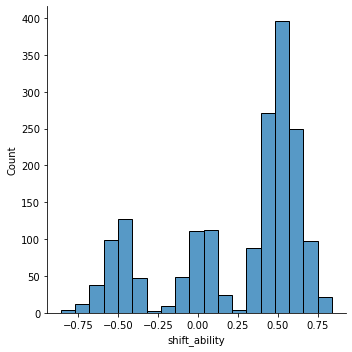

In [105]:
sns.displot(sub_shRNA['shift_ability'])

In [106]:
hi_shift_sh = sub_shRNA[sub_shRNA['shift_ability'] > .5]

In [107]:
hi_shift_sh['cmap_name'].unique().shape

(219,)

In [108]:
hi_shift_cp['cmap_name'].unique().shape

(291,)

In [109]:
# overlap hi-shift targets
hi_shift_target = list(set(hi_shift_sh['cmap_name'].unique()) & set(hi_shift_cp['target'].unique()))

In [110]:
hi_shift_target

['ABL1',
 'IMPA1',
 'MDM2',
 'CYCS',
 'KCNQ1',
 'CLK2',
 'CDK4',
 'ACLY',
 'PRKAA1',
 'EGFR',
 'PTPN1',
 'PSEN1',
 'HDAC1',
 'ASAH1',
 'MAPK3',
 'RRM1',
 'CDK1',
 'BCL2',
 'FGFR1',
 'PPIA',
 'CTSL',
 'AURKA',
 'PAK4',
 'AURKB',
 'BMPR1A',
 'CDC25A',
 'LCK',
 'CSNK2A1',
 'KDR',
 'AXL',
 'DHFR',
 'PIK3CB',
 'PRKCB',
 'TXN',
 'RHOA',
 'PIK3CG',
 'PIM2',
 'TYMS',
 'CASP3',
 'G6PD',
 'HDAC6',
 'HIF1A',
 'SENP2',
 'PRKDC',
 'MTOR',
 'NR3C1',
 'HDAC2',
 'CHEK1',
 'GSK3B',
 'CLK1',
 'F2R',
 'ALK',
 'PRKCD',
 'HMGCR',
 'IKBKB',
 'KIF11',
 'AKT3',
 'CDK2',
 'HRH1',
 'PPAT',
 'ESR1',
 'PTGFR',
 'MAPK14',
 'NPSR1',
 'JAK1',
 'TOP1',
 'VDR',
 'RAF1',
 'FLT3',
 'PSMB1',
 'PLK1',
 'SYK',
 'FLT1',
 'TP53',
 'BRAF',
 'HDAC3',
 'IGF1R',
 'BTK',
 'PARP2',
 'ERBB2',
 'PIK3CA',
 'FKBP1A',
 'RIPK1',
 'AKT1',
 'MET',
 'WEE1',
 'CAMK2A',
 'CFTR',
 'PDGFRB',
 'DPYD',
 'PDK1',
 'EPHA2']

In [111]:
# final potent list
potent_sh = hi_shift_sh[hi_shift_sh['cmap_name'].isin(hi_shift_target)]
potent_cp = hi_shift_cp[hi_shift_cp['target'].isin(hi_shift_target)]

In [112]:
compound_info[compound_info.index.isin(potent_cp['cmap_name'].unique())]['moa'].value_counts()

HDAC inhibitor               20
EGFR inhibitor               15
MTOR inhibitor               14
CDK inhibitor                10
PI3K inhibitor                8
                             ..
Cytochrome P450 inhibitor     1
Cathepsin inhibitor           1
TP53 activator                1
RNA synthesis inhibitor       1
HIF modulator                 1
Name: moa, Length: 90, dtype: int64

In [113]:
potent_sh['cell_line'] = sig_info['cell_iname']
potent_cp['cell_line'] = sig_info['cell_iname']

<ipython-input-113-ef401aedf2f0>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  potent_sh['cell_line'] = sig_info['cell_iname']
<ipython-input-113-ef401aedf2f0>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  potent_cp['cell_line'] = sig_info['cell_iname']


In [114]:
potent_cp

,NREC_profile,REC_profile,cmap_name,nearest_dose,pert_idose,shift_ability,cancer_type,cell_line,target
ERBB2002_J82_24H:BRD-K66175015:10,-0.327901,0.377128,afatinib,10.00,10 uM,0.705029,BLCA,J82,EGFR
REP.A019_MDAMB231_24H:L13,-0.445946,0.507214,dasatinib,10.00,10 uM,0.953159,BRCA,MDAMB231,EPHA2
PBIOA016_MCF7_24H:H03,-0.470885,0.447807,fulvestrant,1.11,1.11 uM,0.918692,BRCA,MCF7,ESR1
REP.A019_MDAMB231_24H:L16,-0.428393,0.490055,dasatinib,0.37,0.37 uM,0.918448,BRCA,MDAMB231,EPHA2
LJP006_MDAMB231_24H:K14,-0.435013,0.479861,NVP-TAE684,3.33,3.33 uM,0.914874,BRCA,MDAMB231,ALK
...,...,...,...,...,...,...,...,...,...
PBIOA017_A375_24H:I13,-0.325388,0.375665,alisertib,10.00,10 uM,0.701053,SKCM,A375,AURKA
PBIOA014_A375_24H:I01,-0.405254,0.295627,TPCA-1,10.00,10 uM,0.700880,SKCM,A375,IKBKB
REP.A026_A375_24H:D14,-0.351262,0.349365,bortezomib,3.33,3.33 uM,0.700627,SKCM,A375,PSMB1
REP.B019_A375_24H:L13,-0.344476,0.356070,dasatinib,2.22,2.22 uM,0.700546,SKCM,A375,EPHA2


In [115]:
potent_sh

,NREC_profile,REC_profile,cmap_name,nearest_dose,pert_idose,shift_ability,cancer_type,cell_line
KDA008_MCF7_96H:TRCN0000004576:-666,-0.316942,0.394415,SENP2,NaN,NaN,0.711357,BRCA,MCF7
KDA008_MCF7_96H:A04,-0.316942,0.394415,SENP2,NaN,NaN,0.711357,BRCA,MCF7
KDA003_MCF7_96H:TRCN0000003898:-666,-0.322699,0.354807,PSMB1,NaN,NaN,0.677507,BRCA,MCF7
KDC008_MCF7_96H:TRCN0000039633:-666,-0.314892,0.335781,EGFR,NaN,NaN,0.650673,BRCA,MCF7
KDD009_MCF7_96H:TRCN0000001598:-666,-0.334414,0.313585,LCK,NaN,NaN,0.647999,BRCA,MCF7
...,...,...,...,...,...,...,...,...
KDA002_A375_96H:E10,-0.285611,0.227096,CASP3,NaN,NaN,0.512707,SKCM,A375
KDC008_A375_96H:TRCN0000003687:-666,-0.221123,0.290544,F2R,NaN,NaN,0.511668,SKCM,A375
KDA002_A375_96H:TRCN0000003551:-666,-0.288906,0.216956,CASP3,NaN,NaN,0.505862,SKCM,A375
KDA002_A375_96H:TRCN0000004826:-666,-0.259609,0.241099,HDAC3,NaN,NaN,0.500709,SKCM,A375


In [116]:
potent_sh[potent_sh['cmap_name'] == 'PAK4']

,NREC_profile,REC_profile,cmap_name,nearest_dose,pert_idose,shift_ability,cancer_type,cell_line
KDB004_HT29_96H:TRCN0000010198:-666,-0.300616,0.315164,PAK4,NaN,NaN,0.615780,CRC,HT29
KDB004_A375_96H:TRCN0000010201:-666,-0.334421,0.243936,PAK4,NaN,NaN,0.578357,SKCM,A375


In [117]:
potent_cp[potent_cp['target'] == 'PAK4']

,NREC_profile,REC_profile,cmap_name,nearest_dose,pert_idose,shift_ability,cancer_type,cell_line,target
REP.A014_MCF7_24H:K17,-0.395146,0.395726,PF-03758309,0.125,0.125 uM,0.790873,BRCA,MCF7,PAK4
REP.A014_HT29_24H:K15,-0.452040,0.363303,PF-03758309,1.110,1.11 uM,0.815343,CRC,HT29,PAK4
REP.A014_HT29_24H:K16,-0.387660,0.348348,PF-03758309,0.370,0.37 uM,0.736008,CRC,HT29,PAK4
REP.A014_HT29_24H:K14,-0.438640,0.288585,PF-03758309,3.330,3.33 uM,0.727225,CRC,HT29,PAK4
LJP009_HCC515_24H:D03,-0.380671,0.326676,PF-03758309,1.110,1.11 uM,0.707347,LUNG,HCC515,PAK4
REP.A014_YAPC_24H:K14,-0.416973,0.307990,PF-03758309,3.330,3.33 uM,0.724963,PAAD,YAPC,PAK4
REP.B014_YAPC_24H:K13,-0.343930,0.365076,PF-03758309,2.220,2.22 uM,0.709005,PAAD,YAPC,PAK4
REP.B014_PC3_24H:K15,-0.420736,0.422244,PF-03758309,0.250,0.25 uM,0.842980,PRAD,PC3,PAK4
REP.A014_PC3_24H:K15,-0.431607,0.365444,PF-03758309,1.110,1.11 uM,0.797051,PRAD,PC3,PAK4
REP.B014_PC3_24H:K13,-0.460567,0.336289,PF-03758309,2.220,2.22 uM,0.796856,PRAD,PC3,PAK4


# 1. Pairing cell line

In [118]:
# shRNA
ctype_sh = pd.crosstab(potent_sh['cmap_name'], potent_sh['cell_line'])

# compound
ctype_cp = pd.crosstab(potent_cp['target'], potent_cp['cell_line'])

In [119]:
ctype_sh

cell_line,A375,A549,HCC515,HEPG2,HT29,MCF7,PC3,SW480,VCAP
cmap_name,,,,,,,,,
ABL1,1,1,0,0,1,1,1,0,1
ACLY,0,0,0,0,0,1,0,0,0
AKT1,0,1,0,2,0,2,2,0,1
AKT3,0,1,0,0,0,0,1,0,0
ALK,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...
TP53,0,0,0,0,0,0,1,0,0
TXN,0,0,0,0,1,0,0,0,0
TYMS,2,0,0,0,0,0,0,0,0


In [120]:
ctype_cp

cell_line,A375,A549,BT20,CL34,DU145,EFO27,HCC515,HELA,HEPG2,HS578T,...,PC3,RKO,RMUGS,SKBR3,SKMEL5,SNUC5,SW620,T3M10,VCAP,YAPC
target,,,,,,,,,,,,,,,,,,,,,
ABL1,10,1,0,0,0,0,5,0,0,0,...,1,0,0,0,0,0,0,0,0,3
ACLY,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AKT1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AKT3,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
ALK,7,3,0,0,0,0,1,0,1,0,...,3,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TP53,3,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
TXN,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
TYMS,4,6,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [122]:
ctype_cp_sh = ctype_cp.T[ctype_cp.columns.isin(ctype_sh.columns)].T

In [123]:
ctype_cp_sh

cell_line,A375,A549,HCC515,HEPG2,HT29,MCF7,PC3,VCAP
target,,,,,,,,
ABL1,10,1,5,0,2,1,1,0
ACLY,0,0,0,0,0,1,0,0
AKT1,0,1,0,0,2,1,0,0
AKT3,0,0,0,0,0,0,1,0
ALK,7,3,1,1,6,0,3,1
...,...,...,...,...,...,...,...,...
TP53,3,1,0,0,0,4,0,0
TXN,0,0,0,0,0,0,0,1
TYMS,4,6,0,0,2,4,0,0


In [124]:
ctype_merge_indicator = ctype_cp_sh * ctype_sh
ctype_merge_indicator = ctype_merge_indicator[ctype_merge_indicator == 0].fillna(1)

In [125]:
ctype_merge_indicator

cell_line,A375,A549,HCC515,HEPG2,HT29,MCF7,PC3,SW480,VCAP
target,,,,,,,,,
ABL1,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0
ACLY,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
AKT1,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
AKT3,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
ALK,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...
TP53,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
TXN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
TYMS,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [126]:
ctype_merge_final = ctype_merge_indicator[ctype_merge_indicator != 0].dropna(axis=0, how='all').dropna(axis=1, how='all').fillna(0)

In [127]:
ctype_merge_final

cell_line,A375,A549,HCC515,HEPG2,HT29,MCF7,PC3,SW480,VCAP
target,,,,,,,,,
ABL1,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0
ACLY,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
AKT1,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
AKT3,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0
ALK,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...
TP53,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
TXN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
TYMS,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


<AxesSubplot:xlabel='cell_line', ylabel='target'>

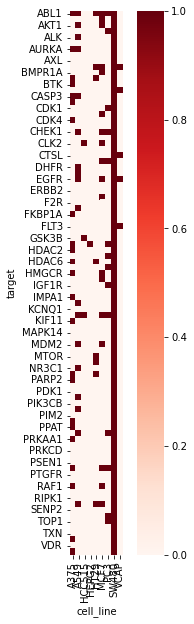

In [129]:
plt.figure(figsize=(5, 10))
sns.heatmap(ctype_merge_final, square=True, cmap='Reds')

In [130]:
# paired target and cell line
pr_tar_cl = []
for i in ctype_merge_final.index:
    for j in ctype_merge_final.columns:
        if ctype_merge_final.loc[i, j] == 1:
            pr_tar_cl.append(i + '_' + j)
print(len(pr_tar_cl))

182


In [131]:
# compound with paired target and cell line
potent_cp['target_cl'] = potent_cp['target'] + '_' + potent_cp['cell_line']
potent_sh['target_cl'] = potent_sh['cmap_name'] + '_' + potent_sh['cell_line']

paired_potent_cp = potent_cp[potent_cp['target_cl'].isin(pr_tar_cl)]
paired_potent_sh = potent_sh[potent_sh['target_cl'].isin(pr_tar_cl)]

<ipython-input-131-a7e19cf55c91>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  potent_cp['target_cl'] = potent_cp['target'] + '_' + potent_cp['cell_line']
<ipython-input-131-a7e19cf55c91>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  potent_sh['target_cl'] = potent_sh['cmap_name'] + '_' + potent_sh['cell_line']


In [132]:
paired_potent_cp

,NREC_profile,REC_profile,cmap_name,nearest_dose,pert_idose,shift_ability,cancer_type,cell_line,target,target_cl
PBIOA016_MCF7_24H:H03,-0.470885,0.447807,fulvestrant,1.11,1.11 uM,0.918692,BRCA,MCF7,ESR1,ESR1_MCF7
ASG002_MCF7_24H:O11,-0.423905,0.480693,raloxifene,1.11,1.11 uM,0.904598,BRCA,MCF7,ESR1,ESR1_MCF7
DOSBIO002_MCF7_24H:BRD-A90490067:1.11111,-0.489857,0.397493,fulvestrant,1.11,1.11 uM,0.887349,BRCA,MCF7,ESR1,ESR1_MCF7
DOSBIO002_MCF7_24H:BRD-A90490067:10,-0.432054,0.454763,fulvestrant,10.00,10 uM,0.886817,BRCA,MCF7,ESR1,ESR1_MCF7
REP.B010_MCF7_24H:N17,-0.431396,0.445505,gemcitabine,0.03,0.03 uM,0.876901,BRCA,MCF7,RRM1,RRM1_MCF7
...,...,...,...,...,...,...,...,...,...,...
MOAR006_A375_24H:C09,-0.298506,0.403869,filanesib,1.11,1.11 uM,0.702375,SKCM,A375,KIF11,KIF11_A375
DOSVAL001_A375_24H:BRD-K81418486:10,-0.387172,0.314976,vorinostat,10.00,10 uM,0.702148,SKCM,A375,HDAC6,HDAC6_A375
PBIOA017_A375_24H:I13,-0.325388,0.375665,alisertib,10.00,10 uM,0.701053,SKCM,A375,AURKA,AURKA_A375
REP.A026_A375_24H:D14,-0.351262,0.349365,bortezomib,3.33,3.33 uM,0.700627,SKCM,A375,PSMB1,PSMB1_A375


In [133]:
paired_potent_sh

,NREC_profile,REC_profile,cmap_name,nearest_dose,pert_idose,shift_ability,cancer_type,cell_line,target_cl
KDA003_MCF7_96H:TRCN0000003898:-666,-0.322699,0.354807,PSMB1,NaN,NaN,0.677507,BRCA,MCF7,PSMB1_MCF7
KDC008_MCF7_96H:TRCN0000039633:-666,-0.314892,0.335781,EGFR,NaN,NaN,0.650673,BRCA,MCF7,EGFR_MCF7
KDA007_MCF7_96H:O16,-0.325045,0.318033,RRM1,NaN,NaN,0.643077,BRCA,MCF7,RRM1_MCF7
KDA007_MCF7_96H:TRCN0000300203:-666,-0.325045,0.318033,RRM1,NaN,NaN,0.643077,BRCA,MCF7,RRM1_MCF7
KDD003_MCF7_96H:TRCN0000001689:-666,-0.309118,0.330742,KDR,NaN,NaN,0.639860,BRCA,MCF7,KDR_MCF7
...,...,...,...,...,...,...,...,...,...
DER001_A375_96H:TRCN0000116501:-666,-0.274825,0.243076,KIF11,NaN,NaN,0.517901,SKCM,A375,KIF11_A375
TAK001_A375_96H:TRCN0000000861:-666,-0.178191,0.335703,PRKAA1,NaN,NaN,0.513894,SKCM,A375,PRKAA1_A375
KDA002_A375_96H:E10,-0.285611,0.227096,CASP3,NaN,NaN,0.512707,SKCM,A375,CASP3_A375
KDA002_A375_96H:TRCN0000003551:-666,-0.288906,0.216956,CASP3,NaN,NaN,0.505862,SKCM,A375,CASP3_A375


In [134]:
# shift ability expectation in the same cell line
null_shift = df(index=pr_tar_cl, columns=['null_sh', 'null_cp'])
for i in null_shift.index:
    tmp_target, tmp_cl = i.split('_')
    null_shift.at[i, 'null_sh'] = merged_shRNA[merged_shRNA['cell_line'] == tmp_cl]['shift_ability'].mean()
    null_shift.at[i, 'null_cp'] = merged_compound[merged_compound['cell_line'] == tmp_cl]['shift_ability'].mean()


In [135]:
null_shift

,null_sh,null_cp
ABL1_A375,0.276757,0.500291
ABL1_A549,0.221269,0.266601
ABL1_HT29,0.272217,0.385746
ABL1_MCF7,0.33699,0.372202
ABL1_PC3,0.208248,0.316123
...,...,...
TYMS_A375,0.276757,0.500291
TYMS_SW480,0.0815749,0.502863
VDR_SW480,0.0815749,0.502863
WEE1_A375,0.276757,0.500291


Text(0, 0.5, 'potent target by cell line')

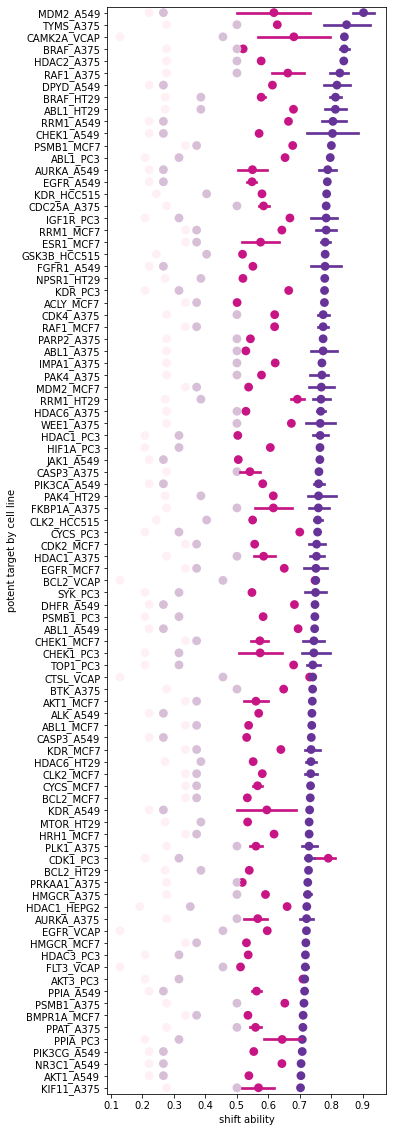

In [137]:
# sort by compound mean shift
target_order = paired_potent_cp.groupby('target_cl').mean().sort_values(by='shift_ability', ascending=False).index

plt.figure(figsize=(5, 20))

# shRNA
sns.pointplot(y='target_cl', x='shift_ability',
              data=paired_potent_sh, order=target_order,
              join=False, alpha=.5, color='mediumvioletred')

# compound
sns.pointplot(y='target_cl', x='shift_ability', data=paired_potent_cp,
              order=target_order, join=False, markers='o',
              color='rebeccapurple')

# null distribution: shRNAs
sns.pointplot(y=null_shift.index, x='null_sh',
              join=False, color='lavenderblush',
              order=target_order, data=null_shift)

# null distribution: compounds
sns.pointplot(y=null_shift.index, x='null_cp',
              join=False,
              order=target_order, data=null_shift,
              color='thistle')
plt.xlabel('shift ability')
plt.ylabel('potent target by cell line')

In [138]:
# relative shift ability from null
relative_shift = df(index=pr_tar_cl, columns=['relative_sh', 'relative_cp'])
for i in relative_shift.index:
    relative_shift.at[i, 'relative_sh'] = paired_potent_sh[paired_potent_sh['target_cl'] == i]['shift_ability'].mean() - null_shift.loc[i, 'null_sh']
    relative_shift.at[i, 'relative_cp'] = paired_potent_cp[paired_potent_cp['target_cl'] == i]['shift_ability'].mean() - null_shift.loc[i, 'null_cp']


Text(0, 0.5, 'potent target by cell line')

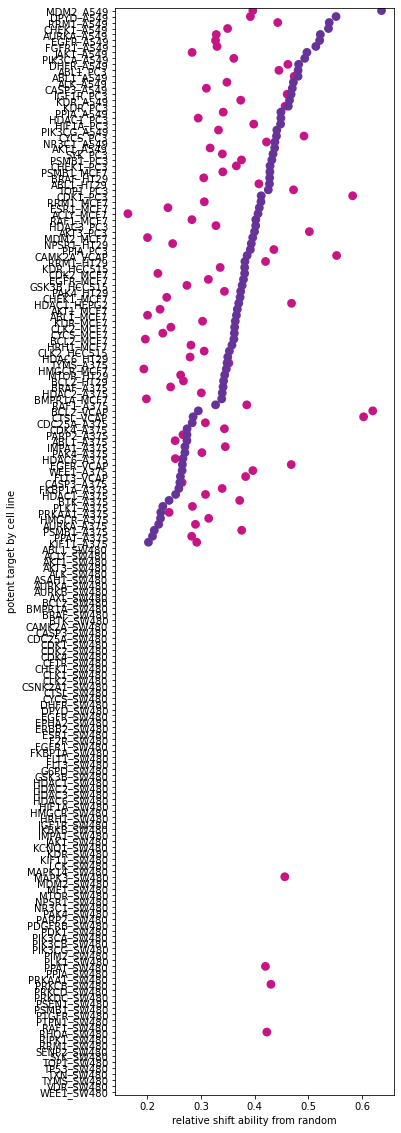

In [139]:
# sort by compound mean shift
target_order = relative_shift.sort_values(by='relative_cp', ascending=False).index

plt.figure(figsize=(5, 20))

# shRNA
sns.pointplot(y=relative_shift.index, x='relative_sh',
              data=relative_shift, order=target_order,
              join=False, alpha=.5, color='mediumvioletred')

# compound
sns.pointplot(y=relative_shift.index, x='relative_cp', data=relative_shift,
              order=target_order, join=False, markers='o',
              color='rebeccapurple')


plt.xlabel('relative shift ability from random')
plt.ylabel('potent target by cell line')

Text(0, 0.5, 'potent target by cell line')

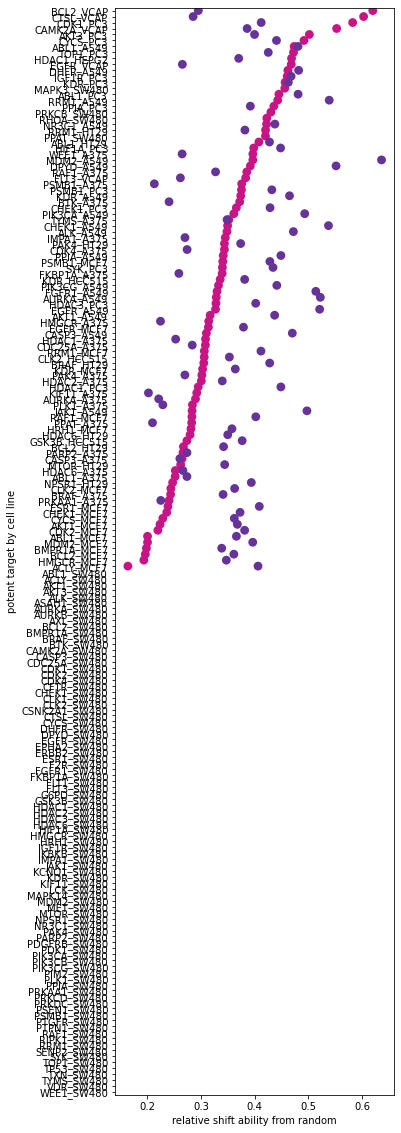

In [140]:
# sort by shRNA mean shift
target_order = relative_shift.sort_values(by='relative_sh', ascending=False).index

plt.figure(figsize=(5, 20))

# shRNA
sns.pointplot(y=relative_shift.index, x='relative_sh',
              data=relative_shift, order=target_order,
              join=False, alpha=.5, color='mediumvioletred')

# compound
sns.pointplot(y=relative_shift.index, x='relative_cp', data=relative_shift,
              order=target_order, join=False, markers='o',
              color='rebeccapurple')


plt.xlabel('relative shift ability from random')
plt.ylabel('potent target by cell line')

# 2. Paired target-cell line by compounds

In [141]:
pd.crosstab(paired_potent_cp['cmap_name'], paired_potent_cp['target_cl'])

target_cl,ABL1_A375,ABL1_A549,ABL1_HT29,ABL1_MCF7,ABL1_PC3,ACLY_MCF7,AKT1_A549,AKT1_MCF7,AKT3_PC3,ALK_A549,...,PSMB1_PC3,RAF1_A375,RAF1_MCF7,RRM1_A549,RRM1_HT29,RRM1_MCF7,SYK_PC3,TOP1_PC3,TYMS_A375,WEE1_A375
cmap_name,,,,,,,,,,,,,,,,,,,,,
ABT-737,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AMG-232,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AVL-292,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AZ-628,0,0,0,0,0,0,0,0,0,0,...,0,10,2,0,0,0,0,0,0,0
AZD-7762,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
vemurafenib,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
volasertib,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
vorinostat,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [142]:
paired_potent_cp['cmap_name'].unique()

array(['fulvestrant', 'raloxifene', 'gemcitabine', 'AMG-232',
       'bazedoxifene', 'tamoxifen', 'Y-134', 'PHA-848125', 'bortezomib',
       'AZD-7762', 'nutlin-3', 'AZ-628', 'dovitinib', 'CHEMBL-399379',
       'foretinib', 'neratinib', 'PHA-793887', 'WZ-3105', 'dinaciclib',
       'MK-2206', 'saracatinib', 'antimycin-a', 'obatoclax', 'azelastine',
       'pitavastatin', 'alvocidib', 'canertinib', 'aminopurvalanol-a',
       'LDN-193189', 'dabrafenib', 'vemurafenib', 'PLX-4720',
       'PF-03758309', 'bosutinib', 'BRD-K37940862', 'GDC-0879',
       'SB-590885', 'vorinostat', 'CEP-32496', 'everolimus', 'voxtalisib',
       'ABT-737', 'belinostat', 'NCH-51', 'mocetinostat', 'fluorouracil',
       'KW-2449', 'taselisib', 'wortmannin', 'alisertib', 'PD-158780',
       'danusertib', 'TWS-119', 'tofacitinib', 'pralatrexate',
       'NVP-TAE684', 'CEP-37440', 'PAC-1', 'cyclosporin-a', 'GDC-0941',
       'mometasone', 'fluticasone-propionate', 'panobinostat',
       'CHEMBL-1222381', 'BMS-75

In [143]:
for tc in paired_potent_cp['target_cl'].unique():
    print(tc)
    tmp_cp = paired_potent_cp[paired_potent_cp['target_cl'] == tc]['cmap_name'].unique()
    print(compound_info.loc[tmp_cp, 'moa'])
    print('\n')

ESR1_MCF7
cmap_name
fulvestrant              Estrogen receptor antagonist
raloxifene               Estrogen receptor antagonist
bazedoxifene    Selective estrogen receptor modulator
tamoxifen                Estrogen receptor antagonist
Y-134                    Estrogen receptor antagonist
Name: moa, dtype: object


RRM1_MCF7
cmap_name
gemcitabine    Ribonucleotide reductase inhibitor
Name: moa, dtype: object


MDM2_MCF7
cmap_name
AMG-232     MDM inhibitor
nutlin-3    MDM inhibitor
Name: moa, dtype: object


CDK2_MCF7
cmap_name
PHA-848125           CDK inhibitor
PHA-793887           CDK inhibitor
dinaciclib           CDK inhibitor
alvocidib            CDK inhibitor
aminopurvalanol-a    CDK inhibitor
Name: moa, dtype: object


PSMB1_MCF7
cmap_name
bortezomib    Proteasome inhibitor
Name: moa, dtype: object


CHEK1_MCF7
cmap_name
AZD-7762    CHK inhibitor
Name: moa, dtype: object


RAF1_MCF7
cmap_name
AZ-628    RAF inhibitor
Name: moa, dtype: object


EGFR_MCF7
cmap_name
dovitinib     EGF

# 3. Compound shifting score, shRNA shifting percentage

In [171]:
# calculate for all
cp_sh_pct = df(sub_compound[['shift_ability', 'cmap_name', 'cell_line', 'target']])
for c in cp_sh_pct.index:
    tmp_cell = cp_sh_pct.loc[c, 'cell_line']
    tmp_target = cp_sh_pct.loc[c, 'target']
    
    if tmp_cell in sub_shRNA['cell_line'].unique():
        if tmp_target in sub_shRNA[sub_shRNA['cell_line'] == tmp_cell]['cmap_name'].unique():
            tmp_sh_c = sub_shRNA[sub_shRNA['cell_line'] == tmp_cell]
            tmp_sh = tmp_sh_c[tmp_sh_c['cmap_name'] == tmp_target]['shift_ability'].mean()
            tmp_p = tmp_sh_c[tmp_sh_c['shift_ability'] >= tmp_sh].shape[0] / tmp_sh_c.shape[0]
            cp_sh_pct.at[c, 'shRNA_ave_shift_percentage'] = tmp_p
            cp_sh_pct.at[c, 'shRNA_ave_shift'] = tmp_sh

In [205]:
cp_sh_pct_cleaned = cp_sh_pct.dropna(axis=0, how='any')
cp_sh_pct_cleaned = cp_sh_pct_cleaned[cp_sh_pct_cleaned['shift_ability'] >= .7]
cp_sh_pct_cleaned

,shift_ability,cmap_name,cell_line,target,shRNA_ave_shift_percentage,shRNA_ave_shift
PBIOA016_MCF7_24H:H03,0.918692,fulvestrant,MCF7,ESR1,0.576208,0.431887
ASG002_MCF7_24H:O11,0.904598,raloxifene,MCF7,ESR1,0.576208,0.431887
DOSBIO002_MCF7_24H:BRD-A90490067:1.11111,0.887349,fulvestrant,MCF7,ESR1,0.576208,0.431887
DOSBIO002_MCF7_24H:BRD-A90490067:10,0.886817,fulvestrant,MCF7,ESR1,0.576208,0.431887
REP.B010_MCF7_24H:N17,0.876901,gemcitabine,MCF7,RRM1,0.100372,0.643077
...,...,...,...,...,...,...
PBIOA017_A375_24H:I13,0.701053,alisertib,A375,AURKA,0.624161,0.383633
PBIOA014_A375_24H:I01,0.700880,TPCA-1,A375,IKBKB,0.546980,0.442681
REP.A026_A375_24H:D14,0.700627,bortezomib,A375,PSMB1,0.097315,0.652431
REP.B019_A375_24H:L13,0.700546,dasatinib,A375,EPHA2,0.755034,0.005354


In [287]:
cp_sh_pct_cleaned['cmap_name'].unique().shape

(187,)

<AxesSubplot:xlabel='shift_ability', ylabel='shRNA_ave_shift_percentage'>

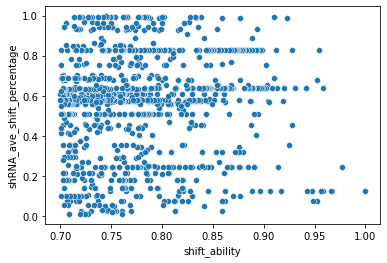

In [206]:
sns.scatterplot(x='shift_ability', y='shRNA_ave_shift_percentage', data=cp_sh_pct_cleaned)

In [207]:
cp_sh_pct_cleaned[cp_sh_pct_cleaned['target'] == 'PAK4']

,shift_ability,cmap_name,cell_line,target,shRNA_ave_shift_percentage,shRNA_ave_shift
REP.A014_HT29_24H:K15,0.815343,PF-03758309,HT29,PAK4,0.102564,0.615780
REP.A014_HT29_24H:K16,0.736008,PF-03758309,HT29,PAK4,0.102564,0.615780
REP.A014_HT29_24H:K14,0.727225,PF-03758309,HT29,PAK4,0.102564,0.615780
LJP009_A375_24H:D02,0.792535,PF-03758309,A375,PAK4,0.248322,0.578357
MOAR004_A375_24H:A17,0.786920,PF-03758309,A375,PAK4,0.248322,0.578357
MOAR004_A375_24H:A18,0.786408,PF-03758309,A375,PAK4,0.248322,0.578357
REP.A014_A375_24H:K13,0.715129,PF-03758309,A375,PAK4,0.248322,0.578357


In [208]:
# take top percentage: top 25% shRNA shifting
top_cp_sh_pct = cp_sh_pct_cleaned[cp_sh_pct_cleaned['shRNA_ave_shift_percentage'] <= .25]
top_cp_sh_pct

,shift_ability,cmap_name,cell_line,target,shRNA_ave_shift_percentage,shRNA_ave_shift
REP.B010_MCF7_24H:N17,0.876901,gemcitabine,MCF7,RRM1,0.100372,0.643077
CPD003_MCF7_24H:M02,0.869401,gemcitabine,MCF7,RRM1,0.100372,0.643077
CPC006_MCF7_24H:P01,0.829455,gemcitabine,MCF7,RRM1,0.100372,0.643077
PBIOA014_MCF7_24H:B15,0.815454,gemcitabine,MCF7,RRM1,0.100372,0.643077
REP.A028_MCF7_24H:G13,0.800399,bortezomib,MCF7,PSMB1,0.211896,0.580490
...,...,...,...,...,...,...
REP.A015_A375_24H:E17,0.704961,dacinostat,A375,HDAC1,0.214765,0.585087
REP.B021_A375_24H:J11,0.704751,JNJ-26481585,A375,HDAC1,0.214765,0.585087
PCLB002_A375_24H:BRD-K84937637:0.12,0.703826,sirolimus,A375,FKBP1A,0.140940,0.616088
PCLB002_A375_24H:BRD-K02130563:3.33,0.702575,panobinostat,A375,HDAC1,0.214765,0.585087


In [586]:
top_cp_sh_pct

,shift_ability,cmap_name,cell_line,target,shRNA_ave_shift_percentage,shRNA_ave_shift,target_cl
REP.B010_MCF7_24H:N17,0.876901,gemcitabine,MCF7,RRM1,0.100372,0.643077,RRM1_MCF7
CPD003_MCF7_24H:M02,0.869401,gemcitabine,MCF7,RRM1,0.100372,0.643077,RRM1_MCF7
CPC006_MCF7_24H:P01,0.829455,gemcitabine,MCF7,RRM1,0.100372,0.643077,RRM1_MCF7
PBIOA014_MCF7_24H:B15,0.815454,gemcitabine,MCF7,RRM1,0.100372,0.643077,RRM1_MCF7
REP.A028_MCF7_24H:G13,0.800399,bortezomib,MCF7,PSMB1,0.211896,0.580490,PSMB1_MCF7
...,...,...,...,...,...,...,...
REP.A015_A375_24H:E17,0.704961,dacinostat,A375,HDAC1,0.214765,0.585087,HDAC1_A375
REP.B021_A375_24H:J11,0.704751,JNJ-26481585,A375,HDAC1,0.214765,0.585087,HDAC1_A375
PCLB002_A375_24H:BRD-K84937637:0.12,0.703826,sirolimus,A375,FKBP1A,0.140940,0.616088,FKBP1A_A375
PCLB002_A375_24H:BRD-K02130563:3.33,0.702575,panobinostat,A375,HDAC1,0.214765,0.585087,HDAC1_A375


In [215]:
# take top shifting
ave_cp_sh_pct = df(columns=['cmap_name', 'cell_line', 'target', 'moa',
                            'ave_cp_shift', 
                            'ave_sh_shift', 'ave_sh_shift_percent'])
for cl in top_cp_sh_pct['cell_line'].unique():
    tmp_cl = top_cp_sh_pct[top_cp_sh_pct['cell_line'] == cl]

    # traverse the compounds
    for c in tmp_cl['cmap_name'].unique():
        tmp_c = tmp_cl[tmp_cl['cmap_name'] == c]
        ave_cp_sh_pct.at[c + '|' + cl, 'cmap_name'] = c
        ave_cp_sh_pct.at[c + '|' + cl, 'cell_line'] = cl
        ave_cp_sh_pct.at[c + '|' + cl, 'target'] = tmp_c['target'].unique()[0]
        ave_cp_sh_pct.at[c + '|' + cl, 'ave_cp_shift'] = tmp_c['shift_ability'].mean()
        ave_cp_sh_pct.at[c + '|' + cl, 'ave_sh_shift_percent']  = tmp_c['shRNA_ave_shift_percentage'].mean()
        ave_cp_sh_pct.at[c + '|' + cl, 'ave_sh_shift']  = tmp_c['shRNA_ave_shift'].mean()
        ave_cp_sh_pct.at[c + '|' + cl, 'moa'] = compound_info.loc[c, 'moa']

In [216]:
top_hit.sort_values(by='ave_sh_shift_percent', ascending=True)

,cmap_name,cell_line,target,moa,ave_cp_shift,ave_sh_shift,ave_sh_shift_percent
CGP-60474|PC3,CGP-60474,PC3,CDK1,CDK inhibitor,0.728132,0.790539,0.00977199
mocetinostat|HEPG2,mocetinostat,HEPG2,HDAC1,HDAC inhibitor,0.722239,0.659682,0.0136986
ABT-737|VCAP,ABT-737,VCAP,BCL2,BCL inhibitor,0.750789,0.748428,0.0206186
gemcitabine|HT29,gemcitabine,HT29,RRM1,Ribonucleotide reductase inhibitor,0.767436,0.692327,0.025641
bosutinib|A549,bosutinib,A549,ABL1,Src inhibitor,0.747181,0.694699,0.030303
SID-26681509|VCAP,SID-26681509,VCAP,CTSL,Cathepsin inhibitor,0.741085,0.731403,0.0309278
pralatrexate|A549,pralatrexate,A549,DHFR,Dihydrofolate reductase inhibitor,0.748312,0.682985,0.0505051
CHEMBL-1222381|VCAP,CHEMBL-1222381,VCAP,CAMK2A,Neural stem cell inducer,0.841674,0.681187,0.0515464
bisbenzimide|PC3,bisbenzimide,PC3,TOP1,DNA binding agent,0.727536,0.680457,0.0553746
camptothecin|PC3,camptothecin,PC3,TOP1,Topoisomerase inhibitor,0.730871,0.680457,0.0553746


In [587]:
top_hit.sort_values(by='ave_cp_shift', ascending=False)

,cmap_name,cell_line,target,moa,ave_cp_shift,ave_sh_shift,ave_sh_shift_percent
AMG-232|A549,AMG-232,A549,MDM2,MDM inhibitor,0.915717,0.61771,0.124579
nutlin-3|A549,nutlin-3,A549,MDM2,MDM inhibitor,0.889551,0.61771,0.124579
raltitrexed|A375,raltitrexed,A375,TYMS,Thymidylate synthase inhibitor,0.861843,0.628486,0.124161
dabrafenib|HT29,dabrafenib,HT29,BRAF,RAF inhibitor,0.846821,0.550812,0.24359
trifluridine|A375,trifluridine,A375,TYMS,Thymidylate synthase inhibitor,0.844413,0.628486,0.124161
CHEMBL-1222381|VCAP,CHEMBL-1222381,VCAP,CAMK2A,Neural stem cell inducer,0.841674,0.681187,0.0515464
PLX-4720|HT29,PLX-4720,HT29,BRAF,RAF inhibitor,0.808127,0.550812,0.24359
Merck60|A375,Merck60,A375,HDAC1,HDAC inhibitor,0.805742,0.585087,0.214765
gemcitabine|A549,gemcitabine,A549,RRM1,Ribonucleotide reductase inhibitor,0.805266,0.664067,0.0740741
irinotecan|PC3,irinotecan,PC3,TOP1,Topoisomerase inhibitor,0.800783,0.680457,0.0553746


In [218]:
top_hit[top_hit['target'].isin(bitarget_gene_info.index)]

,cmap_name,cell_line,target,moa,ave_cp_shift,ave_sh_shift,ave_sh_shift_percent
gemcitabine|MCF7,gemcitabine,MCF7,RRM1,Ribonucleotide reductase inhibitor,0.783772,0.643077,0.100372
gemcitabine|HT29,gemcitabine,HT29,RRM1,Ribonucleotide reductase inhibitor,0.767436,0.692327,0.025641
PF-03758309|HT29,PF-03758309,HT29,PAK4,P21 activated kinase inhibitor,0.759525,0.61578,0.102564
gemcitabine|A549,gemcitabine,A549,RRM1,Ribonucleotide reductase inhibitor,0.805266,0.664067,0.0740741
pralatrexate|A549,pralatrexate,A549,DHFR,Dihydrofolate reductase inhibitor,0.748312,0.682985,0.0505051
trifluridine|A375,trifluridine,A375,TYMS,Thymidylate synthase inhibitor,0.844413,0.628486,0.124161
raltitrexed|A375,raltitrexed,A375,TYMS,Thymidylate synthase inhibitor,0.861843,0.628486,0.124161
sirolimus|A375,sirolimus,A375,FKBP1A,MTOR inhibitor,0.759014,0.616088,0.14094
palbociclib|A375,palbociclib,A375,CDK4,CDK inhibitor,0.774333,0.62028,0.137584
PF-03758309|A375,PF-03758309,A375,PAK4,P21 activated kinase inhibitor,0.770248,0.578357,0.248322


In [220]:
top_hit.shape

(54, 7)

In [288]:
top_hit['moa'].unique().shape

(27,)

In [222]:
top_hit['target'].unique()

array(['RRM1', 'PSMB1', 'CLK2', 'CYCS', 'HRH1', 'BRAF', 'PAK4', 'HDAC1',
       'MDM2', 'PIK3CA', 'DHFR', 'ABL1', 'ALK', 'KDR', 'CAMK2A', 'BCL2',
       'CTSL', 'EGFR', 'TOP1', 'SYK', 'HIF1A', 'CDK1', 'TYMS', 'FKBP1A',
       'CDK4', 'WEE1', 'BTK'], dtype=object)

In [223]:
top_hit['target'].unique().shape

(27,)

In [225]:
top_hit['cell_line'].unique().shape

(8,)

In [226]:
top_hit['cmap_name'].unique().shape

(49,)

In [267]:
top_hit[['ave_cp_shift', 'target']].groupby('target').mean(numeric_only=False)

,ave_cp_shift
target,
ABL1,0.747181
ALK,0.738326
BCL2,0.750789
BRAF,0.788894
BTK,0.740778
CAMK2A,0.841674
CDK1,0.728132
CDK4,0.774333
CLK2,0.734745


Text(0, 0.5, 'Potent targets')

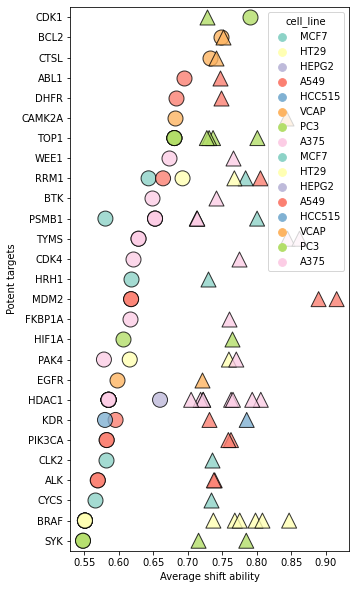

In [276]:
# 27 drug target, 49 drug, 8 cell line
# sort by sh mean shift
target_order = df(top_hit[['ave_sh_shift', 'target']].groupby('target').mean(numeric_only=False)).sort_values(by='ave_sh_shift', ascending=False).index


plt.figure(figsize=(5, 10))

# shRNA
sns.stripplot(y='target', x='ave_sh_shift',
              data=top_hit, order=target_order, linewidth=1, edgecolor='k',
              jitter=False, dodge=False, palette='Set3', 
              alpha=.8, hue='cell_line', marker='o', s=15)

# compound
sns.stripplot(y='target', x='ave_cp_shift',
              data=top_hit, order=target_order,
              jitter=False, dodge=False, palette='Set3', linewidth=1, edgecolor='k',
              alpha=.8, hue='cell_line', marker='^', s=15)


plt.xlabel('Average shift ability')
plt.ylabel('Potent targets')

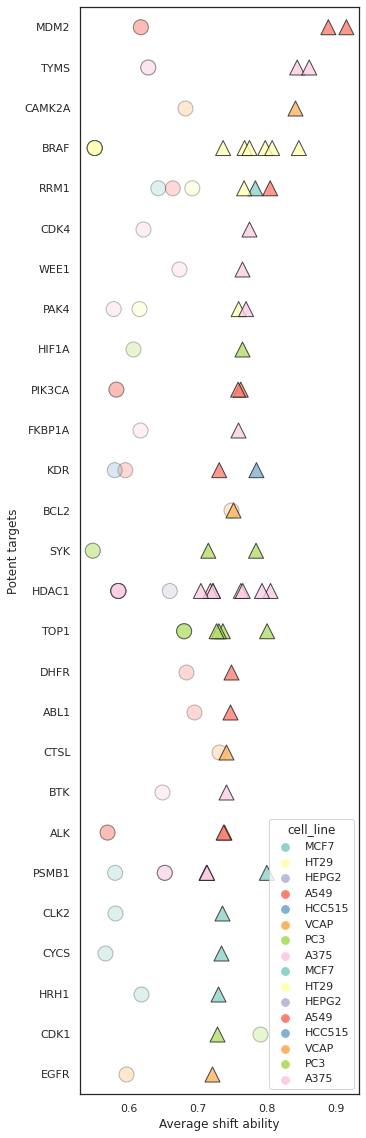

In [353]:
# 27 drug target, 49 drug, 8 cell line
# sort by cp mean shift
target_order = df(top_hit[['ave_cp_shift', 'target']].groupby('target').mean(numeric_only=False)).sort_values(by='ave_cp_shift', ascending=False).index


plt.figure(figsize=(5, 20))

# shRNA
sns.stripplot(y='target', x='ave_sh_shift',
              data=top_hit, order=target_order, linewidth=1, edgecolor='k',
              jitter=False, dodge=False, palette='Set3', 
              alpha=.3, hue='cell_line', marker='o', s=15)

# compound
sns.stripplot(y='target', x='ave_cp_shift',
              data=top_hit, order=target_order,
              jitter=False, dodge=False, palette='Set3', linewidth=1, edgecolor='k',
              alpha=.8, hue='cell_line', marker='^', s=15)


plt.xlabel('Average shift ability')
plt.ylabel('Potent targets')
fig = plt.gcf()
fig.savefig(poseidon_home + 'panels/Figure5/top_hit_cmap.pdf', transparent=True)

In [348]:
top_hit[top_hit['target'] == 'BTK']

,cmap_name,cell_line,target,moa,ave_cp_shift,ave_sh_shift,ave_sh_shift_percent
AVL-292|A375,AVL-292,A375,BTK,BTK inhibitor,0.740778,0.648745,0.100671


In [278]:
top_hit[top_hit['target'].isin(bitarget_gene_info.index)]['target'].unique()

array(['RRM1', 'PAK4', 'DHFR', 'TYMS', 'FKBP1A', 'CDK4'], dtype=object)

In [355]:
top_hit.sort_values(by='target')

,cmap_name,cell_line,target,moa,ave_cp_shift,ave_sh_shift,ave_sh_shift_percent
bosutinib|A549,bosutinib,A549,ABL1,Src inhibitor,0.747181,0.694699,0.030303
CEP-37440|A549,CEP-37440,A549,ALK,ALK inhibitor,0.737724,0.569462,0.205387
NVP-TAE684|A549,NVP-TAE684,A549,ALK,ALK inhibitor,0.738928,0.569462,0.205387
ABT-737|VCAP,ABT-737,VCAP,BCL2,BCL inhibitor,0.750789,0.748428,0.0206186
SB-590885|HT29,SB-590885,HT29,BRAF,RAF inhibitor,0.775239,0.550812,0.24359
GDC-0879|HT29,GDC-0879,HT29,BRAF,RAF inhibitor,0.768083,0.550812,0.24359
PLX-4720|HT29,PLX-4720,HT29,BRAF,RAF inhibitor,0.808127,0.550812,0.24359
CEP-32496|HT29,CEP-32496,HT29,BRAF,RAF inhibitor,0.737006,0.550812,0.24359
vemurafenib|HT29,vemurafenib,HT29,BRAF,RAF inhibitor,0.798089,0.550812,0.24359
dabrafenib|HT29,dabrafenib,HT29,BRAF,RAF inhibitor,0.846821,0.550812,0.24359


In [589]:
top_hit.to_csv('/home/dyang-server/hdd/Yue/PROJECTS/POSEIDON/Tables/TableS5/top_hit_merged.csv', sep=',')

# 4. Potent target corr with TCGA immunity

In [289]:
expr_tcga = pd.read_csv(data_home + 'top_hits_27_genes_TCGA_expr.csv',
                        header=0, index_col=0, sep=',')

In [300]:
expr_tcga.head()

,TCGA-33-6737-01A,TCGA-25-2409-01A,TCGA-QR-A6GT-01A,TCGA-CJ-4908-01A,TCGA-Q1-A73O-01A,TCGA-D8-A1XK-01A,TCGA-CN-5355-01A,TCGA-A6-5659-01A,TCGA-CQ-6221-01A,TCGA-G3-A7M8-01A,...,TCGA-A6-2682-01A,TCGA-EE-A3AD-06A,TCGA-A4-7584-01A,TCGA-BP-5176-01A,TCGA-29-1697-01A,TCGA-A2-A04Q-01A,TCGA-IQ-A61H-01A,TCGA-B8-A54G-01A,TCGA-AP-A3K1-01A,TCGA-WE-A8ZT-06A
0,,,,,,,,,,,,,,,,,,,,,
HRH1,15.800968,16.651561,16.214476,16.592988,17.551312,16.645605,17.053895,16.687525,17.440280,12.990412,...,16.652780,12.226135,16.768256,15.362043,14.416422,15.044742,16.114695,15.277623,16.507128,10.560210
PAK4,18.883607,18.578145,17.213351,16.982373,17.844516,17.949261,17.941397,16.390811,18.124963,17.207351,...,18.825992,17.235956,17.884792,17.651439,19.070019,18.436638,17.900045,17.035411,18.364824,17.514089
CYCS,19.583215,19.179118,20.139522,18.179930,19.427627,19.450142,19.431416,20.687282,19.738522,20.317956,...,20.038393,18.992318,20.207365,18.623865,19.275460,19.195069,20.748418,18.432069,19.466480,19.428452
PIK3CA,15.284978,16.395342,16.186084,16.873992,17.179666,16.993287,16.841732,16.969450,17.137957,15.456955,...,14.830537,16.865229,15.985143,15.970552,16.090083,15.938784,17.132581,16.070058,15.757566,16.292227
CDK4,19.309045,19.180367,19.152495,18.286814,19.378416,19.487008,19.628103,19.420100,19.895642,17.821372,...,20.350367,19.679939,18.627513,18.491378,19.944299,19.220818,19.906734,17.760892,17.696593,19.083094


In [291]:
# TCGA clincal
clinical_tcga = pd.read_csv('/home/dyang-server/hdd/Yue/PROJECTS/collaboration/TCGA-GDC/clinical_PANCAN_patient_with_followup.tsv',
                            header=0, index_col=0, sep='\t', usecols=['bcr_patient_barcode', 'acronym'], encoding='ISO-8859–1')
print(clinical_tcga.head())

                    acronym
bcr_patient_barcode        
TCGA-OR-A5J1            ACC
TCGA-OR-A5J2            ACC
TCGA-OR-A5J3            ACC
TCGA-OR-A5J4            ACC
TCGA-OR-A5J5            ACC


In [295]:
immunity_tcga = pd.read_csv('/home/dyang-server/hdd/Yue/TCGA_GDC/immuneScore/TCGA_pancancer_10852whitelistsamples_68ImmuneSigs.csv',
                            header=0, index_col=0, sep=',')
p_rename = {}
for p in immunity_tcga.columns:
    p_rename[p] = p[:16]
immunity_tcga = immunity_tcga.rename(columns=p_rename)

In [297]:
immunity_class = pd.read_csv(data_home + 'immuneSig/signature_class.csv',
                             header=0, index_col=0, sep=',')
immunity_class

,class
signatures,
MHC1_21978456,Antigen Presentation
MHC2_21978456,Antigen Presentation
MHC.I_19272155,Antigen Presentation
MHC.II_19272155,Antigen Presentation
PD1_data,Check Point
...,...
GRANS_PCA_16704732,Other
Buck14_score,Other
Module11_Prolif_score,Proliferation


In [298]:
immunity_tcga_by_class = immunity_tcga.copy()
immunity_tcga_by_class['class'] = immunity_class['class']
immunity_tcga_by_class = immunity_tcga_by_class.groupby('class').mean()

In [299]:
immunity_tcga_by_class

,TCGA-02-0047-01A,TCGA-02-0055-01A,TCGA-02-2483-01A,TCGA-02-2485-01A,TCGA-02-2486-01A,TCGA-04-1348-01A,TCGA-04-1357-01A,TCGA-04-1362-01A,TCGA-04-1364-01A,TCGA-04-1365-01A,...,TCGA-09-1659-01B,TCGA-13-A5FT-01A,TCGA-29-A5NZ-01A,TCGA-3P-A9WA-01A,TCGA-59-A5PD-01A,TCGA-5X-AA5U-01A,TCGA-OY-A56P-01A,TCGA-OY-A56Q-01A,TCGA-VG-A8LO-01A,TCGA-WR-A838-01A
class,,,,,,,,,,,,,,,,,,,,,
Antigen Presentation,-0.364000,0.738600,-0.133850,-0.741400,0.747250,1.424825,1.451275,-0.569375,-1.621775,0.438950,...,1.043450,-0.746875,-1.064875,-1.199925,-0.944875,-1.932200,-1.523250,-2.022675,-0.800550,-1.046650
B cell,-0.573467,-0.048783,-0.591700,-0.655550,-0.248067,0.388917,1.019283,-0.763233,-1.015200,0.439550,...,-0.100217,0.007800,0.166850,-0.552733,-0.172417,-0.944267,-0.923950,-1.265500,-0.362233,-0.611833
Check Point,-0.702250,1.093375,-1.458125,0.087625,0.690875,0.912000,1.749625,-1.401750,-2.874375,0.496625,...,-0.378250,-0.807000,-0.586875,-1.172500,-0.995000,-2.067000,-1.298625,-2.089125,-0.868875,-1.193125
Chemokine,-1.722400,0.278900,-1.313700,-0.458500,-0.171300,1.127100,1.534500,-0.983100,-2.440300,1.394600,...,0.163200,-0.746300,-0.588000,-0.936500,0.042100,-1.790600,-2.428900,-3.172200,-1.310800,-2.548100
Cytokine,-0.150557,0.945614,-0.309200,-0.140000,0.203300,0.106500,0.046700,-0.277571,-0.952529,0.044786,...,0.013086,-0.156557,0.117743,-0.514157,-0.233286,-0.524357,-0.544771,-1.354929,-0.381343,-0.849371
Cytotoxic T cell,-0.889340,-0.018140,-0.629000,-0.202560,0.028760,0.797960,1.176680,-0.626740,-1.356340,0.378100,...,0.104940,-0.737500,-0.720400,-0.946680,-0.968640,-1.743360,-1.107280,-1.495520,-0.738960,-0.797480
DC cells,0.090800,-0.245100,-0.123300,0.103067,-0.297800,-0.078133,0.580333,-0.021033,-0.294167,0.148433,...,-0.476200,-0.039467,-0.053967,-0.087233,-0.358367,-0.220400,-0.344467,-0.276567,-0.604333,-0.634000
IFN Signaling,-0.589260,0.010930,-0.697820,0.527750,1.278960,0.769480,1.160770,0.348620,-0.648760,1.262640,...,0.830130,0.927440,0.003410,0.412060,-0.822250,-0.778190,0.147140,-1.278020,0.043010,0.217230
Leukocyte,-0.850367,0.067767,-0.651711,-0.550633,0.426111,0.385033,1.175033,-0.845456,-2.234600,0.320633,...,-0.185056,-0.957744,-0.748344,-1.003156,-0.611822,-1.905122,-2.042756,-2.103089,-1.214667,-1.810133


In [312]:
corr_top_hit_immune = {}
for ct in clinical_tcga['acronym'].unique():
    tmp_p = clinical_tcga[clinical_tcga['acronym'] == ct]
    tmp_rho = df(index=expr_tcga.index, columns=immunity_tcga_by_class.index)
    tmp_pvalue = df(index=expr_tcga.index, columns=immunity_tcga_by_class.index)
    
    tmp_p_merged = list(set(expr_tcga.columns) & set(immunity_tcga_by_class.columns))
    tmp_p_ct = [p for p in tmp_p_merged if p[:12] in tmp_p.index]
    sub_expr = expr_tcga[tmp_p_ct].T.groupby(level=0).mean()
    sub_im = immunity_tcga_by_class[tmp_p_ct].T.groupby(level=0).mean()
    sub_expr = sub_expr.loc[sub_im.index, :]
    
    for g in sub_expr.columns:
        for i in sub_im.columns:
            tmp_rho.at[g, i], tmp_pvalue.at[g, i] = stats.pearsonr(sub_expr[g], sub_im[i])
    corr_top_hit_immune[ct] = {}
    corr_top_hit_immune[ct]['rho'] = tmp_rho
    corr_top_hit_immune[ct]['pvalue'] = tmp_pvalue

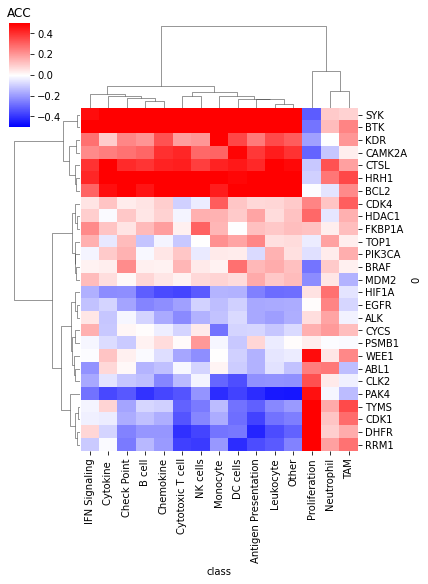

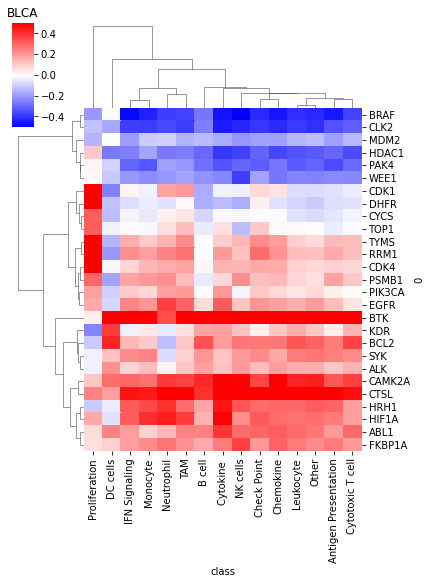

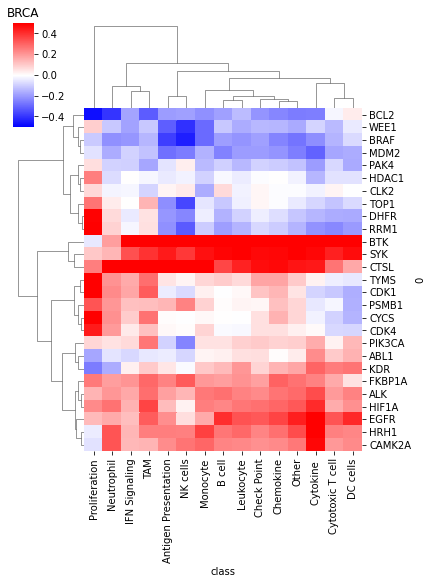

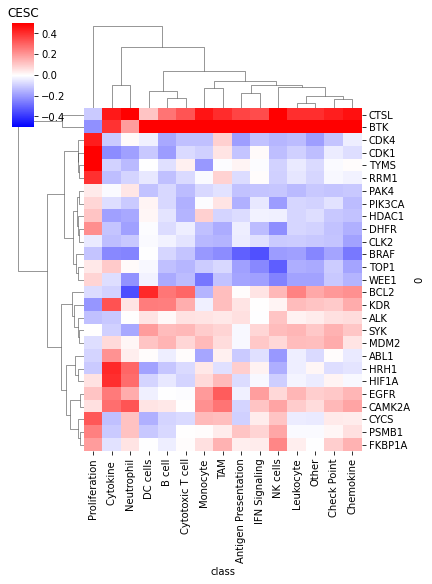

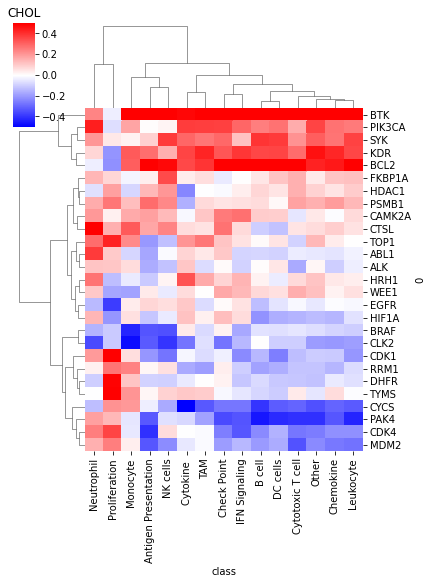

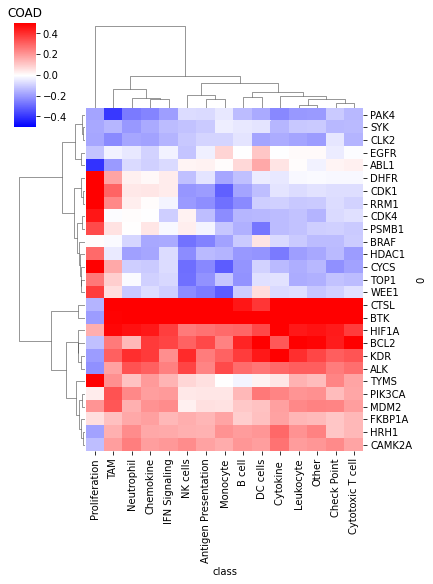

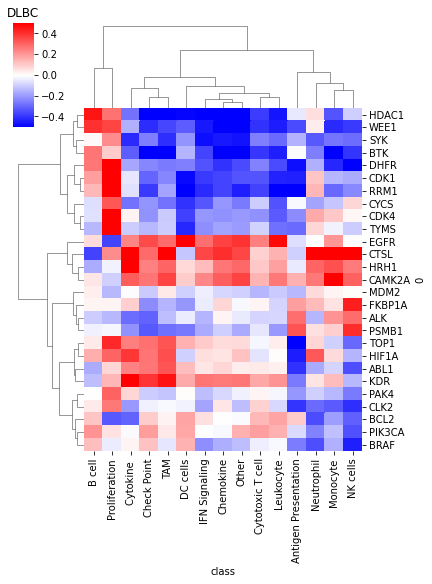

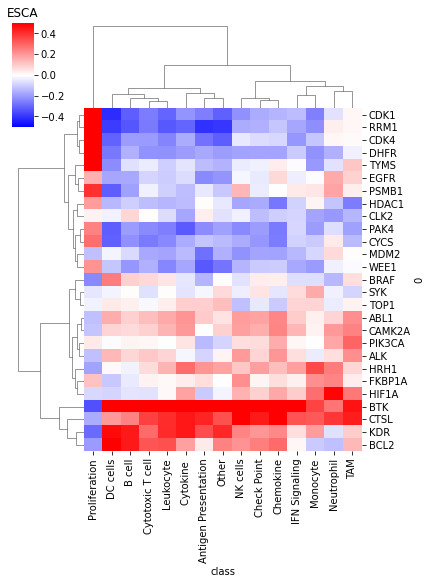

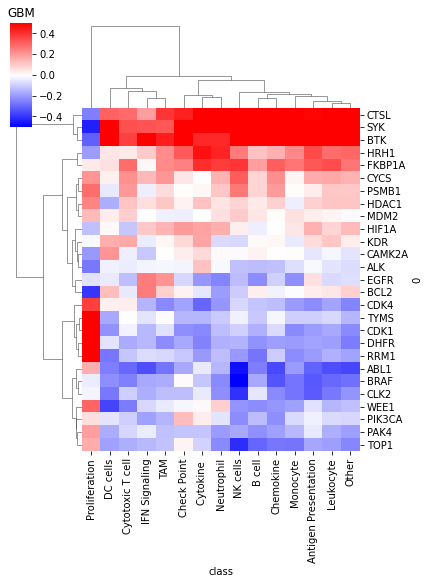

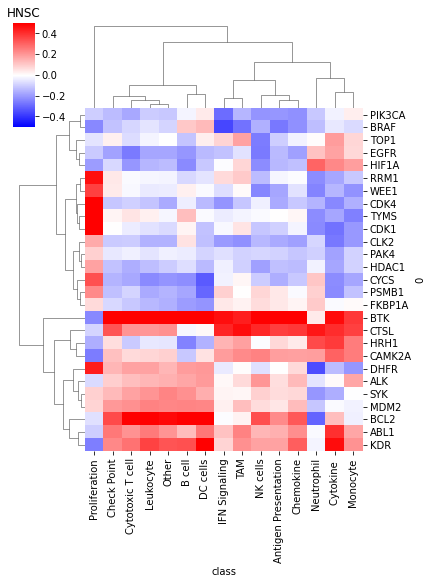

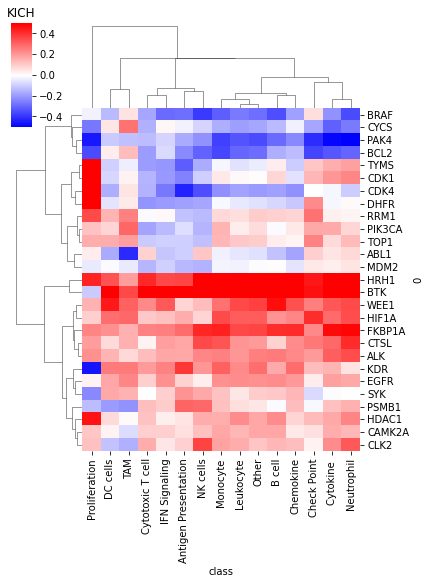

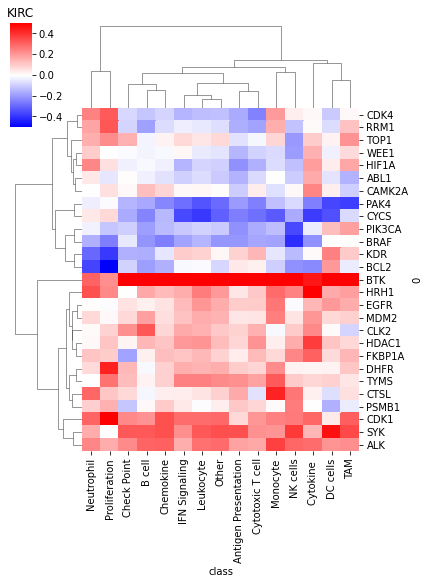

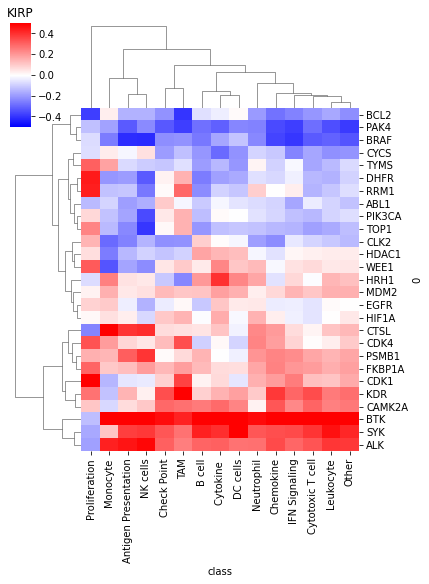

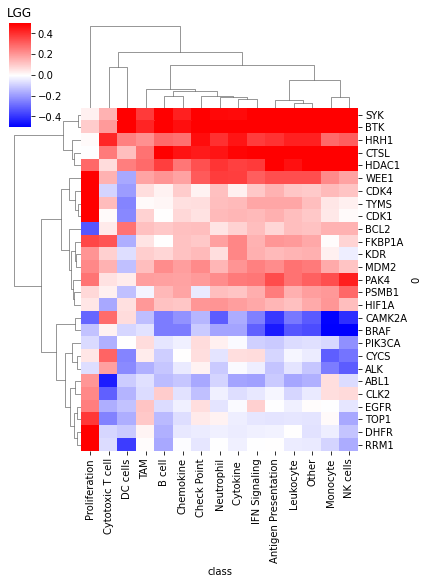

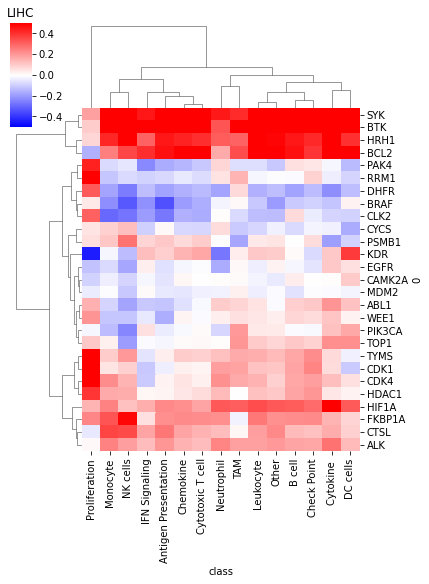

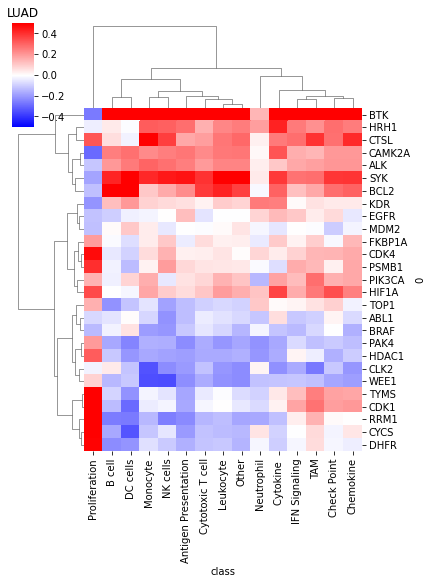

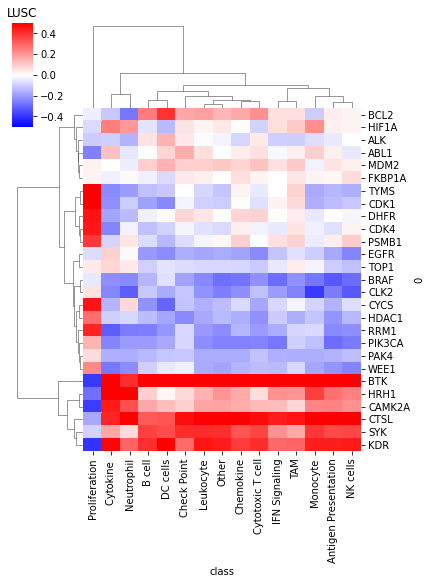

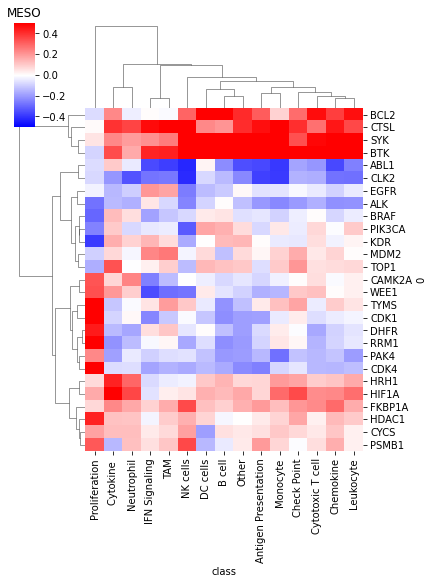

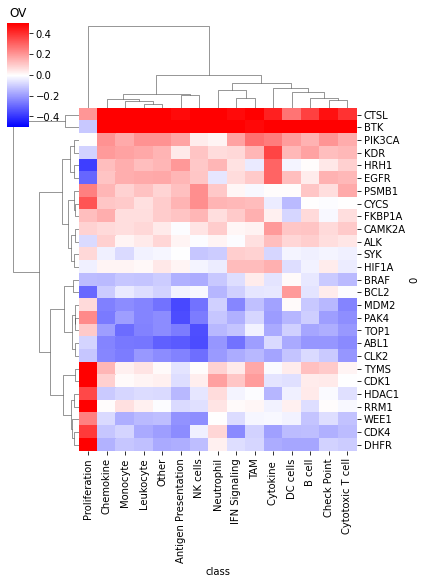

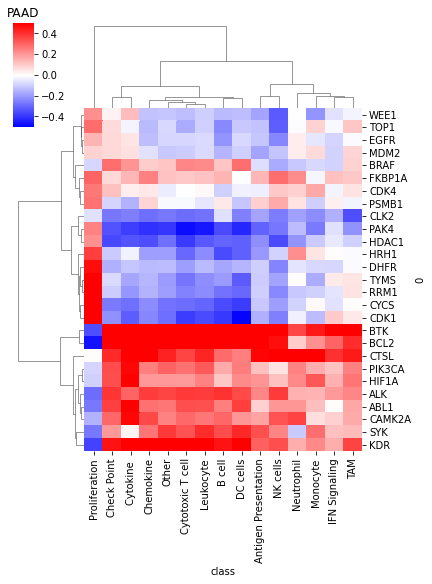

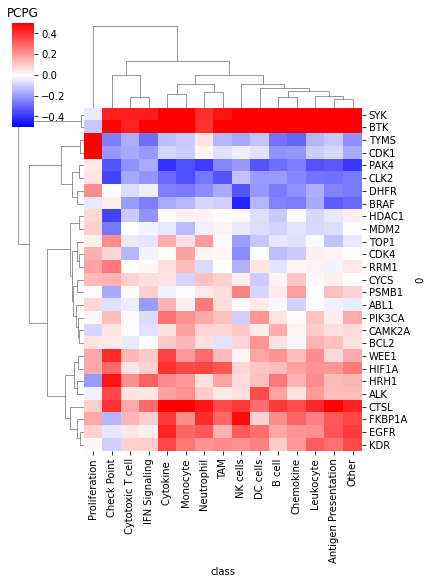

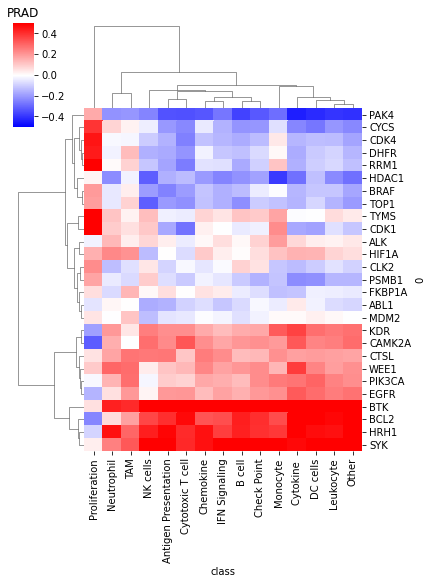

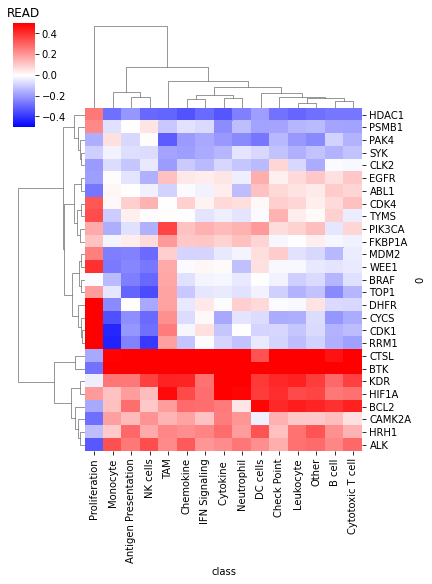

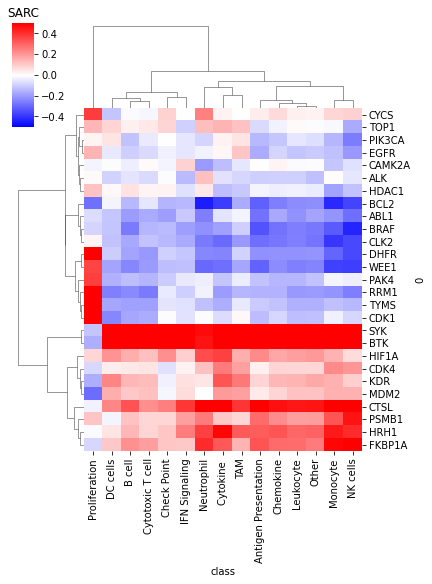

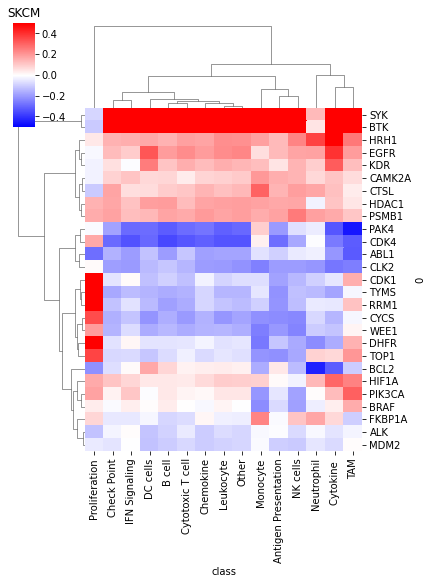

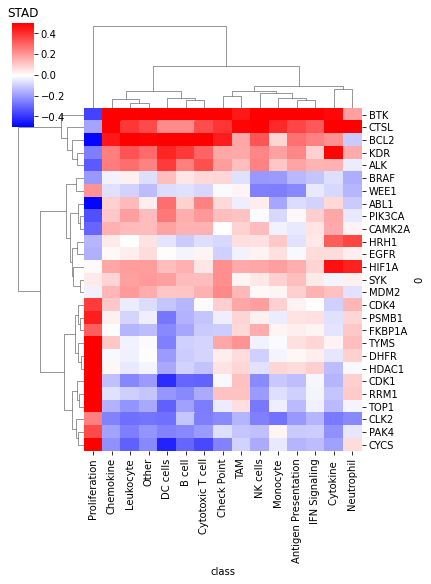

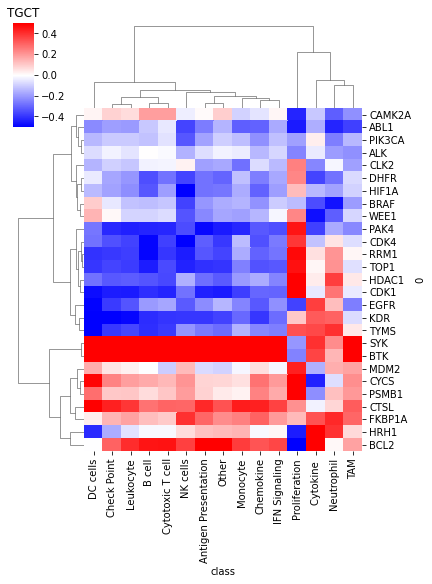

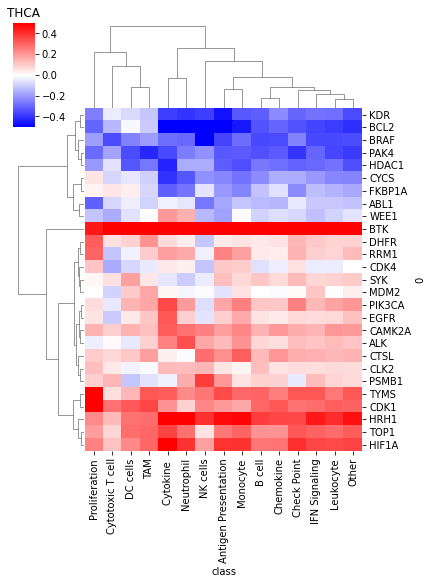

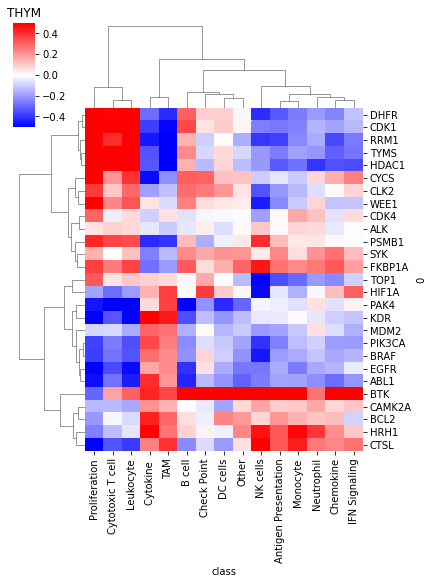

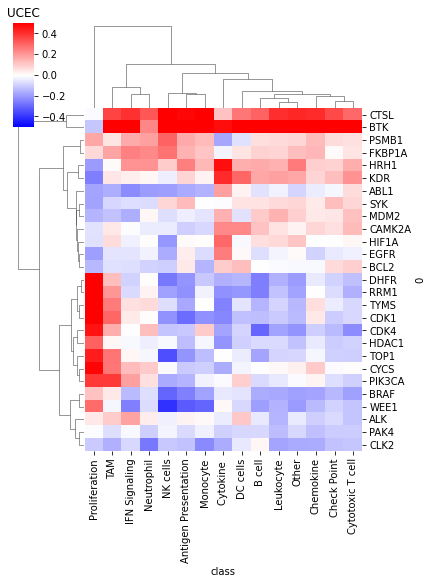

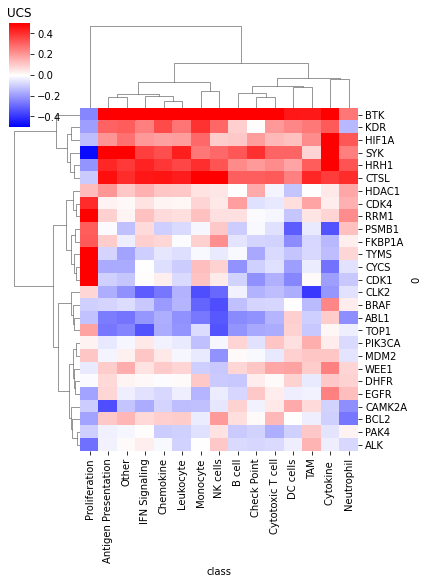

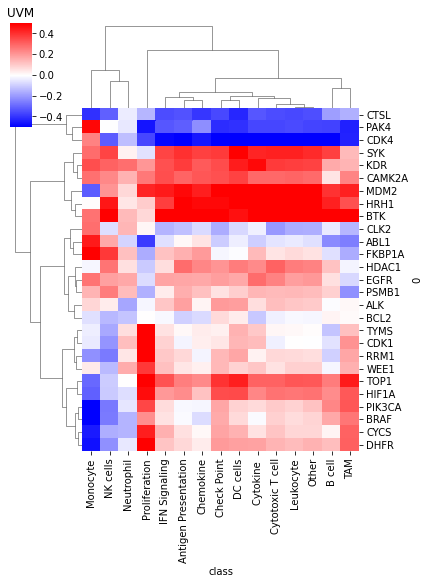

In [317]:
for ct in corr_top_hit_immune:
    sns.clustermap(corr_top_hit_immune[ct]['rho'].astype(float), figsize=(6, 8),
                   method='ward', vmin=-.5, vmax=.5, cmap='bwr')
    plt.title(ct)
    plt.show()

In [318]:
# sig count
pos_count = df(index=expr_tcga.index, columns=immunity_tcga_by_class.index).fillna(0)
neg_count = df(index=expr_tcga.index, columns=immunity_tcga_by_class.index).fillna(0)

for ct in corr_top_hit_immune:
    tmp_ct = corr_top_hit_immune[ct]
    tmp_ct_p = tmp_ct['pvalue']
    tmp_ct_p = tmp_ct_p[tmp_ct_p < 0.05].fillna(0)
    
    tmp_ct_sign = np.sign(tmp_ct_p) * np.sign(tmp_ct['rho'])
    
    tmp_ct_pos = tmp_ct_sign[tmp_ct_sign > 0].fillna(0)
    tmp_ct_neg = tmp_ct_sign[tmp_ct_sign < 0].fillna(0)
    
    pos_count = pos_count + tmp_ct_pos
    neg_count = neg_count + tmp_ct_neg

In [322]:
pos_count.shape[1]

15

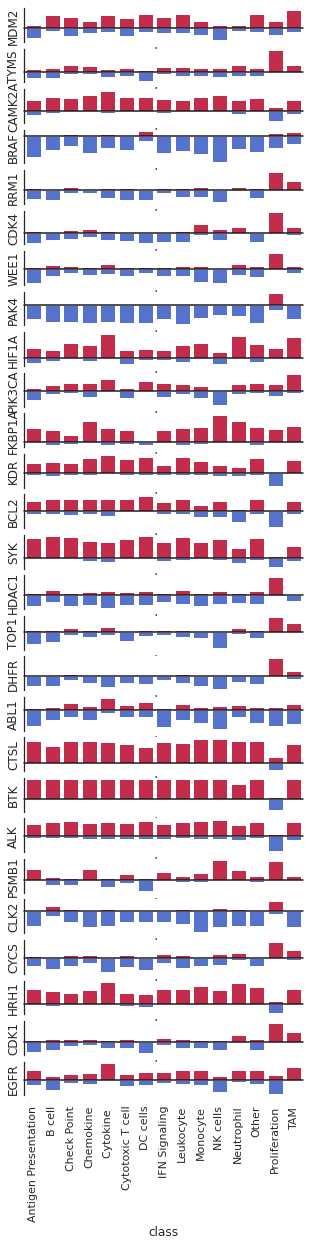

In [354]:
# visual by stacked bar matrix
sns.set_theme(style='white')
f, axes = plt.subplots(pos_count.shape[0], 1, figsize=(5, 20), sharex=True)
for i in range(len(target_order)):
    sns.barplot(x=pos_count.columns, y=pos_count.loc[target_order[i], :], ax=axes[i], color='crimson')
    sns.barplot(x=neg_count.columns, y=neg_count.loc[target_order[i], :], ax=axes[i], color='royalblue')
    axes[i].axhline(y=0., color='k', clip_on=False)
sns.despine(bottom=True)
plt.setp(f.axes, yticks=[])
plt.xticks(rotation=90)
fig = plt.gcf()
fig.savefig(poseidon_home + 'panels/Figure5/top_hit_tcga.pdf', transparent=True)

In [590]:
pos_count.to_csv('/home/dyang-server/hdd/Yue/PROJECTS/POSEIDON/Tables/TableS5/TCGA_immunity_positive_corr.csv', sep=',')

In [592]:
neg_count.to_csv('/home/dyang-server/hdd/Yue/PROJECTS/POSEIDON/Tables/TableS5/TCGA_immunity_negative_corr.csv', sep=',')

In [356]:
neg_count

class,Antigen Presentation,B cell,Check Point,Chemokine,Cytokine,Cytotoxic T cell,DC cells,IFN Signaling,Leukocyte,Monocyte,NK cells,Neutrophil,Other,Proliferation,TAM
0,,,,,,,,,,,,,,,
HRH1,-1.0,-2.0,0.0,-1.0,0.0,-2.0,-4.0,0.0,-1.0,0.0,-1.0,0.0,-1.0,-12.0,-1.0
PAK4,-19.0,-22.0,-22.0,-24.0,-22.0,-24.0,-24.0,-18.0,-25.0,-17.0,-13.0,-14.0,-24.0,-7.0,-18.0
CYCS,-11.0,-15.0,-12.0,-8.0,-20.0,-13.0,-17.0,-7.0,-14.0,-11.0,-10.0,-3.0,-12.0,-1.0,-3.0
PIK3CA,-11.0,-4.0,-2.0,-7.0,-1.0,-8.0,-1.0,-7.0,-4.0,-8.0,-17.0,-4.0,-3.0,-6.0,-2.0
CDK4,-15.0,-11.0,-9.0,-6.0,-10.0,-12.0,-15.0,-13.0,-13.0,-4.0,-10.0,-2.0,-13.0,-1.0,-4.0
DHFR,-16.0,-16.0,-7.0,-11.0,-18.0,-12.0,-13.0,-6.0,-12.0,-16.0,-21.0,-9.0,-14.0,0.0,-4.0
EGFR,-5.0,-9.0,-3.0,-4.0,-1.0,-6.0,-5.0,-3.0,-4.0,-5.0,-11.0,-2.0,-4.0,-13.0,-1.0
ABL1,-14.0,-9.0,-6.0,-9.0,-2.0,-6.0,-6.0,-15.0,-9.0,-11.0,-17.0,-6.0,-11.0,-14.0,-12.0
SYK,-1.0,0.0,-1.0,-3.0,-4.0,-1.0,0.0,-3.0,-2.0,0.0,-2.0,-5.0,-2.0,-10.0,-3.0


In [363]:
# 5 cancer type in 5 signature
neg_count_filter = neg_count[neg_count <= -5].dropna(axis=0, how='all').fillna(0)
neg_count_filter = df(neg_count_filter[neg_count_filter == 0].fillna(1).sum(axis=1))
neg_count_filter = neg_count_filter[neg_count_filter[0] >= 5]
neg_count_filter = neg_count_filter.sort_values(by=0, ascending=False)

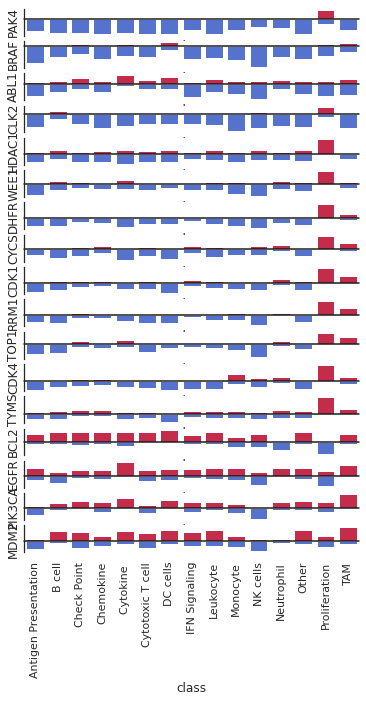

In [436]:
# visual by stacked bar matrix
sns.set_theme(style='white')
f, axes = plt.subplots(neg_count_filter.shape[0], 1, figsize=(6, 10), sharex=True)
for i in range(len(neg_count_filter.index)):
    sns.barplot(x=pos_count.columns, y=pos_count.loc[neg_count_filter.index[i], :], ax=axes[i], color='crimson')
    sns.barplot(x=neg_count.columns, y=neg_count.loc[neg_count_filter.index[i], :], ax=axes[i], color='royalblue')
    axes[i].axhline(y=0., color='k', clip_on=False)
sns.despine(bottom=True)
plt.setp(f.axes, yticks=[])
plt.xticks(rotation=90)
fig = plt.gcf()
fig.savefig(poseidon_home + 'panels/Figure5/top_hit_tcga_selected.pdf', transparent=True)

In [366]:
neg_count_filter.shape

(17, 1)

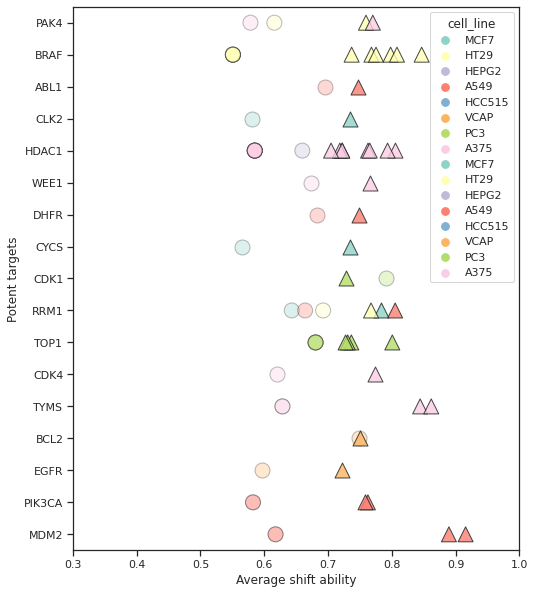

In [377]:
# 17 drug target, 8 cell line
# sort by cp mean shift
target_order = df(top_hit[['ave_cp_shift', 'target']].groupby('target').mean(numeric_only=False)).sort_values(by='ave_cp_shift', ascending=False)
target_order = target_order[target_order.index.isin(neg_count_filter.index)].index

plt.figure(figsize=(8, 10))
sns.set_style('ticks')
# shRNA
sns.stripplot(y='target', x='ave_sh_shift',
              data=top_hit, order=neg_count_filter.index, linewidth=1, edgecolor='k',
              jitter=False, dodge=False, palette='Set3', 
              alpha=.3, hue='cell_line', marker='o', s=15)

# compound
sns.stripplot(y='target', x='ave_cp_shift',
              data=top_hit, order=neg_count_filter.index,
              jitter=False, dodge=False, palette='Set3', linewidth=1, edgecolor='k',
              alpha=.8, hue='cell_line', marker='^', s=15)

plt.xlim(.3, 1)
plt.xlabel('Average shift ability')
plt.ylabel('Potent targets')
fig = plt.gcf()
fig.savefig(poseidon_home + 'panels/Figure5/top_hit_cmap_neg_selected.pdf', transparent=True)

In [378]:
top_hit

,cmap_name,cell_line,target,moa,ave_cp_shift,ave_sh_shift,ave_sh_shift_percent
gemcitabine|MCF7,gemcitabine,MCF7,RRM1,Ribonucleotide reductase inhibitor,0.783772,0.643077,0.100372
bortezomib|MCF7,bortezomib,MCF7,PSMB1,Proteasome inhibitor,0.800399,0.58049,0.211896
WZ-3105|MCF7,WZ-3105,MCF7,CLK2,CLK inhibitor,0.734745,0.58083,0.208178
antimycin-a|MCF7,antimycin-a,MCF7,CYCS,ATP synthase inhibitor,0.734186,0.565783,0.245353
azelastine|MCF7,azelastine,MCF7,HRH1,Histamine receptor antagonist,0.729746,0.618224,0.144981
dabrafenib|HT29,dabrafenib,HT29,BRAF,RAF inhibitor,0.846821,0.550812,0.24359
vemurafenib|HT29,vemurafenib,HT29,BRAF,RAF inhibitor,0.798089,0.550812,0.24359
PLX-4720|HT29,PLX-4720,HT29,BRAF,RAF inhibitor,0.808127,0.550812,0.24359
gemcitabine|HT29,gemcitabine,HT29,RRM1,Ribonucleotide reductase inhibitor,0.767436,0.692327,0.025641
PF-03758309|HT29,PF-03758309,HT29,PAK4,P21 activated kinase inhibitor,0.759525,0.61578,0.102564


In [383]:
sub_shRNA['target_cl'] = sub_shRNA['cmap_name'] + '_' + sub_shRNA['cell_line']
top_cp_sh_pct['target_cl'] = top_cp_sh_pct['target'] + '_' + top_cp_sh_pct['cell_line']
sub_compound['target_cl'] = sub_compound['target'] + '_' + sub_compound['cell_line']

top_shRNA = sub_shRNA[sub_shRNA['target_cl'].isin(top_cp_sh_pct['target_cl'])]
top_compound = sub_compound[sub_compound['target_cl'].isin(top_cp_sh_pct['target_cl'])]

<ipython-input-383-16ec6fd486ef>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub_shRNA['target_cl'] = sub_shRNA['cmap_name'] + '_' + sub_shRNA['cell_line']
<ipython-input-383-16ec6fd486ef>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_cp_sh_pct['target_cl'] = top_cp_sh_pct['target'] + '_' + top_cp_sh_pct['cell_line']
<ipython-input-383-16ec6fd486ef>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inste

In [382]:
top_shRNA

,NREC_profile,REC_profile,cmap_name,nearest_dose,pert_idose,shift_ability,cancer_type,cell_line,target_cl
KDA003_MCF7_96H:TRCN0000003898:-666,-0.322699,0.354807,PSMB1,NaN,NaN,0.677507,BRCA,MCF7,PSMB1_MCF7
KDA007_MCF7_96H:O16,-0.325045,0.318033,RRM1,NaN,NaN,0.643077,BRCA,MCF7,RRM1_MCF7
KDA007_MCF7_96H:TRCN0000300203:-666,-0.325045,0.318033,RRM1,NaN,NaN,0.643077,BRCA,MCF7,RRM1_MCF7
KDC009_MCF7_96H:TRCN0000011675:-666,-0.282458,0.335766,HRH1,NaN,NaN,0.618224,BRCA,MCF7,HRH1_MCF7
KDA010_MCF7_96H:TRCN0000229971:-666,-0.240428,0.340402,CLK2,NaN,NaN,0.580830,BRCA,MCF7,CLK2_MCF7
...,...,...,...,...,...,...,...,...,...
KDB010_A375_96H:TRCN0000349638:-666,-0.163294,0.421356,HDAC1,NaN,NaN,0.584650,SKCM,A375,HDAC1_A375
KDB004_A375_96H:TRCN0000010201:-666,-0.334421,0.243936,PAK4,NaN,NaN,0.578357,SKCM,A375,PAK4_A375
TAK002_A375_96H:TRCN0000349638:-666,-0.230001,0.343323,HDAC1,NaN,NaN,0.573324,SKCM,A375,HDAC1_A375
KDA002_A375_96H:L05,-0.286124,0.270115,FKBP1A,NaN,NaN,0.556239,SKCM,A375,FKBP1A_A375


In [388]:
top_compound = top_compound[top_compound['shift_ability'] >= 0.7]

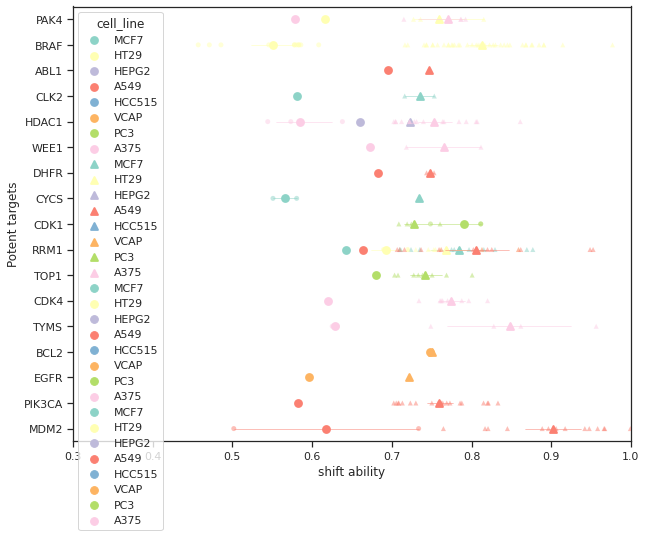

In [439]:
target_order = df(top_hit[['ave_cp_shift', 'target']].groupby('target').mean(numeric_only=False)).sort_values(by='ave_cp_shift', ascending=False)
target_order = target_order[target_order.index.isin(neg_count_filter.index)]

plt.figure(figsize=(10, 8))
sns.set_style('ticks')

# shRNA
sns.pointplot(y='cmap_name', x='shift_ability', hue_order=top_compound['cell_line'].unique(),
              data=top_shRNA, order=neg_count_filter.index, errwidth=.5,
              jitter=False, join=False, dodge=False, palette='Set3', 
              alpha=.8, hue='cell_line', markers='o', s=15)

# compound
sns.pointplot(y='target', x='shift_ability', hue_order=top_compound['cell_line'].unique(),
              data=top_compound, order=neg_count_filter.index,
              jitter=False, join=False, dodge=False, palette='Set3', errwidth=.5,
              alpha=.8, hue='cell_line', markers='^', s=15)

# shRNA
sns.stripplot(y='cmap_name', x='shift_ability', hue_order=top_compound['cell_line'].unique(),
              data=top_shRNA, order=neg_count_filter.index,
              # linewidth=1, edgecolor='k',
              jitter=False, dodge=False, palette='Set3', 
              alpha=.5, hue='cell_line', marker='o', s=5)

# compound
sns.stripplot(y='target', x='shift_ability', hue_order=top_compound['cell_line'].unique(),
              data=top_compound, order=neg_count_filter.index,
              jitter=False, dodge=False, palette='Set3',
              # linewidth=1, edgecolor='k',
              alpha=.5, hue='cell_line', marker='^', s=5)

plt.xlim(.3, 1)
plt.xlabel('shift ability')
plt.ylabel('Potent targets')
fig = plt.gcf()
fig.savefig(poseidon_home + 'panels/Figure5/top_hit_cmap_neg_selected.pdf', transparent=True)

In [443]:
top_hit.sort_values(by='target')

,cmap_name,cell_line,target,moa,ave_cp_shift,ave_sh_shift,ave_sh_shift_percent
bosutinib|A549,bosutinib,A549,ABL1,Src inhibitor,0.747181,0.694699,0.030303
CEP-37440|A549,CEP-37440,A549,ALK,ALK inhibitor,0.737724,0.569462,0.205387
NVP-TAE684|A549,NVP-TAE684,A549,ALK,ALK inhibitor,0.738928,0.569462,0.205387
ABT-737|VCAP,ABT-737,VCAP,BCL2,BCL inhibitor,0.750789,0.748428,0.0206186
SB-590885|HT29,SB-590885,HT29,BRAF,RAF inhibitor,0.775239,0.550812,0.24359
GDC-0879|HT29,GDC-0879,HT29,BRAF,RAF inhibitor,0.768083,0.550812,0.24359
PLX-4720|HT29,PLX-4720,HT29,BRAF,RAF inhibitor,0.808127,0.550812,0.24359
CEP-32496|HT29,CEP-32496,HT29,BRAF,RAF inhibitor,0.737006,0.550812,0.24359
vemurafenib|HT29,vemurafenib,HT29,BRAF,RAF inhibitor,0.798089,0.550812,0.24359
dabrafenib|HT29,dabrafenib,HT29,BRAF,RAF inhibitor,0.846821,0.550812,0.24359


In [446]:
# generate GSEA curves for given case
def case_gsea_compound(drug_name, shift_result):
    # initialize
    gsea_result = {}
    
    # extract signature
    tmp_sig = shift_result[shift_result['cmap_name'] == drug_name]
    
    # get the GSEA
    for s in tmp_sig.index:
        p_rename = '__'.join(s.split(':'))
        rnk = pd.read_csv(gsea_home + shift_result.loc[s, 'cancer_type'] + '/trt_cp/' + p_rename + '.rnk', header=None, sep="\t")
        pre_res = gp.prerank(rnk=rnk, gene_sets=gsea_home + '/gene_sets/NREC_REC_91061.gmt',
                             processes=20,
                             permutation_num=1,
                             outdir=None, seed=0, min_size=10, max_size=2000)

        # save results
        gsea_result[s] = {}
        gsea_result[s]['R_sig'] = {} 
        gsea_result[s]['S_sig'] = {}

        # save R sig
        gsea_result[s]['R_sig']['hit_indices'] = pre_res.results['NREC_profile']['hit_indices']
        tmp_res = []
        for i in pre_res.results['NREC_profile']['hit_indices']:
            tmp_res.append(pre_res.results['NREC_profile']['RES'][i])
        gsea_result[s]['R_sig']['RES'] = tmp_res

        # save S sig
        gsea_result[s]['S_sig']['hit_indices'] = pre_res.results['REC_profile']['hit_indices']
        tmp_res = []
        for i in pre_res.results['REC_profile']['hit_indices']:
            tmp_res.append(pre_res.results['REC_profile']['RES'][i])
        gsea_result[s]['S_sig']['RES'] = tmp_res
    
    return gsea_result

In [447]:
# generate GSEA curves for given case
def case_gsea_shRNA(target_name, shift_result):
    # initialize
    gsea_result = {}
    
    # extract signature
    tmp_sig = shift_result[shift_result['cmap_name'] == target_name]
    
    # get the GSEA
    for s in tmp_sig.index:
        p_rename = '__'.join(s.split(':'))
        rnk = pd.read_csv(gsea_home + shift_result.loc[s, 'cancer_type'] + '/trt_sh/' + p_rename + '.rnk', header=None, sep="\t")
        pre_res = gp.prerank(rnk=rnk, gene_sets=gsea_home + '/gene_sets/NREC_REC_91061.gmt',
                             processes=20,
                             permutation_num=1,
                             outdir=None, seed=0, min_size=10, max_size=2000)

        # save results
        gsea_result[s] = {}
        gsea_result[s]['R_sig'] = {} 
        gsea_result[s]['S_sig'] = {}

        # save R sig
        gsea_result[s]['R_sig']['hit_indices'] = pre_res.results['NREC_profile']['hit_indices']
        tmp_res = []
        for i in pre_res.results['NREC_profile']['hit_indices']:
            tmp_res.append(pre_res.results['NREC_profile']['RES'][i])
        gsea_result[s]['R_sig']['RES'] = tmp_res

        # save S sig
        gsea_result[s]['S_sig']['hit_indices'] = pre_res.results['REC_profile']['hit_indices']
        tmp_res = []
        for i in pre_res.results['REC_profile']['hit_indices']:
            tmp_res.append(pre_res.results['REC_profile']['RES'][i])
        gsea_result[s]['S_sig']['RES'] = tmp_res
    
    return gsea_result

In [583]:
def visual_gsea(drug_name, shift_result, gsea_curves, ylim_l, ylim_h, figsize, save_path=None):
    # extract signature
    tmp_sig = shift_result[shift_result['cmap_name'] == drug_name]
    
    plt.figure(figsize=figsize)
    for s in gsea_curves.keys():
        if s in tmp_sig.index:
            sns.lineplot(x=gsea_curves[s]['R_sig']['hit_indices'],
                         y=gsea_curves[s]['R_sig']['RES'],
                         linewidth=.5,
                         color='crimson', alpha=.8)

            sns.lineplot(x=gsea_curves[s]['S_sig']['hit_indices'],
                         y=gsea_curves[s]['S_sig']['RES'],
                         linewidth=.5,
                         color='royalblue', alpha=.8)
    
    plt.title(drug_name + ', n=' + str(tmp_sig.shape[0]))
    plt.xlim(0, 10174)
    plt.ylim(ylim_l, ylim_h)
    plt.yticks(rotation=90)
    plt.ylabel('Enrichment Score')
    plt.axhline(y=0., ls='--', c='k')
    plt.tight_layout()
    fig = plt.gcf()
    if save_path is not None:
        fig.savefig(save_path, transparent=True)
        plt.close()
    else:
        plt.show()
    
    return

In [450]:
case_PAK4_cp = case_gsea_compound(drug_name='PF-03758309', shift_result=top_compound)
case_PAK4_sh = case_gsea_shRNA(target_name='PAK4', shift_result=top_shRNA)

In [462]:
visual_gsea(drug_name='PF-03758309',
            shift_result=top_compound,
            gsea_curves=case_PAK4_cp,
            ylim_l=-.5, ylim_h=.5,
            figsize=(4, 3),
            save_path=poseidon_home + 'panels/Figure5/case_PAK4i.pdf')

In [463]:
visual_gsea(drug_name='PAK4',
            shift_result=top_shRNA,
            gsea_curves=case_PAK4_sh,
            ylim_l=-.4, ylim_h=.4,
            figsize=(4, 3),
            save_path=poseidon_home + 'panels/Figure5/case_shPAK4.pdf')

In [578]:
pak4_all = sub_compound[sub_compound['cmap_name'] == 'PF-03758309']

In [579]:
pak4_all

,NREC_profile,REC_profile,cmap_name,nearest_dose,pert_idose,shift_ability,cancer_type,cell_line,target,target_cl
REP.A014_MCF7_24H:K17,-0.395146,0.395726,PF-03758309,0.125,0.125 uM,0.790873,BRCA,MCF7,PAK4,PAK4_MCF7
REP.A014_MCF7_24H:K15,-0.361099,0.288309,PF-03758309,1.110,1.11 uM,0.649409,BRCA,MCF7,PAK4,PAK4_MCF7
REP.B014_MCF7_24H:K13,-0.266355,0.308703,PF-03758309,2.220,2.22 uM,0.575058,BRCA,MCF7,PAK4,PAK4_MCF7
REP.B014_MCF7_24H:K16,-0.265991,0.307735,PF-03758309,0.080,0.08 uM,0.573726,BRCA,MCF7,PAK4,PAK4_MCF7
REP.A014_MCF7_24H:K13,-0.298327,0.273402,PF-03758309,10.000,10 uM,0.571729,BRCA,MCF7,PAK4,PAK4_MCF7
...,...,...,...,...,...,...,...,...,...,...
REP.A014_A375_24H:K16,-0.251660,0.292566,PF-03758309,0.370,0.37 uM,0.544226,SKCM,A375,PAK4,PAK4_A375
REP.B014_A375_24H:K15,-0.216803,0.282341,PF-03758309,0.250,0.25 uM,0.499144,SKCM,A375,PAK4,PAK4_A375
LJP009_A375_24H:D03,-0.320887,0.149351,PF-03758309,1.110,1.11 uM,0.470238,SKCM,A375,PAK4,PAK4_A375
REP.A014_A375_24H:K17,-0.233447,0.208398,PF-03758309,0.125,0.125 uM,0.441845,SKCM,A375,PAK4,PAK4_A375


In [580]:
case_PAK4_all = case_gsea_compound(drug_name='PF-03758309', shift_result=pak4_all)

In [584]:
for cl in pak4_all['cell_line'].unique():
    tmp_pak4 = pak4_all[pak4_all['cell_line'] == cl]
    visual_gsea(drug_name='PF-03758309',
            shift_result=tmp_pak4,
            gsea_curves=case_PAK4_all,
            ylim_l=-.5, ylim_h=.5,
            figsize=(4, 3),
            save_path=poseidon_home + 'panels/Figure5/case_PAK4i_' + cl + '.pdf')

# TIMER estimation

In [464]:
# correlation between PAK4 and immune infiltration
timer_estimation = pd.read_csv(poseidon_home + 'panels/Figure1/infiltration/timer_estimation.csv',
                               header=0, index_col=0, sep=',')

In [465]:
timer_estimation

,B_cell,T_cell.CD4,T_cell.CD8,Neutrophil,Macrophage,DC
TCGA-OR-A5J1-01A,0.109517,0.126832,0.209947,0.110269,0.066581,0.489240
TCGA-OR-A5J2-01A,0.111422,0.122945,0.213529,0.108902,0.065820,0.496165
TCGA-OR-A5J3-01A,0.110691,0.117283,0.209806,0.106531,0.055763,0.489622
TCGA-OR-A5J5-01A,0.106686,0.118828,0.206969,0.106482,0.055488,0.486803
TCGA-OR-A5J6-01A,0.106231,0.125072,0.212350,0.110023,0.087343,0.506979
...,...,...,...,...,...,...
TCGA-NF-A5CP-01A,0.122051,0.128950,0.220369,0.129573,0.043174,0.534149
TCGA-NG-A4VU-01A,0.106601,0.127402,0.195710,0.102776,0.026950,0.506280
TCGA-NG-A4VW-01A,0.120219,0.113667,0.226401,0.106125,0.034189,0.503815
TCGA-QM-A5NM-01A,0.107160,0.135303,0.184621,0.104712,0.018168,0.496925


In [479]:
timer_pak4_rho = df(index=clinical_tcga['acronym'].unique(), columns=timer_estimation.columns)
timer_pak4_p = df(index=clinical_tcga['acronym'].unique(), columns=timer_estimation.columns)
for ct in clinical_tcga['acronym'].unique():
    tmp_p = clinical_tcga[clinical_tcga['acronym'] == ct]
    
    tmp_p_merged = list(set(expr_tcga.columns) & set(timer_estimation.index))
    tmp_p_ct = [p for p in tmp_p_merged if p[:12] in tmp_p.index]
    if len(tmp_p_ct) > 10:
        sub_expr = expr_tcga[tmp_p_ct].T.groupby(level=0).mean()
        sub_im = timer_estimation[timer_estimation.index.isin(tmp_p_ct)].groupby(level=0).mean()
        sub_expr = df(sub_expr.loc[sub_im.index, 'PAK4'])

        for i in sub_im.columns:
            timer_pak4_rho.at[ct, i], timer_pak4_p.at[ct, i] = stats.pearsonr(sub_expr['PAK4'], sub_im[i])
timer_pak4_p = timer_pak4_p.dropna(axis=0, how='all')
timer_pak4_rho = timer_pak4_rho.dropna(axis=0, how='all')

In [480]:
timer_pak4_rho

,B_cell,T_cell.CD4,T_cell.CD8,Neutrophil,Macrophage,DC
ACC,-0.380464,-0.160514,-0.406618,-0.355887,-0.457608,-0.425428
BLCA,-0.179912,-0.2752,-0.254265,-0.353297,-0.155145,-0.378642
BRCA,-0.151861,-0.19744,-0.296923,-0.331347,-0.334684,-0.248734
CESC,0.0108501,-0.0433869,-0.113394,-0.126178,-0.0499142,-0.111029
COAD,-0.184965,-0.080925,-0.361552,-0.289014,-0.289375,-0.238795
DLBC,-0.0803817,0.0247184,-0.268383,-0.0197535,-0.0356662,0.0551615
GBM,-0.0249652,-0.0636039,-0.0733302,-0.127028,-0.19876,-0.112681
HNSC,0.00283121,-0.102511,-0.0153359,-0.130485,-0.179807,-0.128383
KICH,-0.307771,-0.502466,-0.175944,-0.318794,-0.612985,-0.668218
KIRC,-0.277234,-0.306246,-0.284301,-0.507485,-0.504739,-0.364972


In [499]:
timer_pak4_p

,B_cell,T_cell.CD4,T_cell.CD8,Neutrophil,Macrophage,DC
ACC,0.000542617,0.157621,0.000200392,0.00128705,2.23489e-05,9.28998e-05
BLCA,0.000264041,1.65921e-08,1.99788e-07,2.07715e-13,0.00169327,2.53647e-15
BRCA,5.267e-07,5.80787e-11,1.92228e-23,4.09998e-29,1.05404e-29,1.04713e-16
CESC,0.85056,0.45102,0.0482308,0.0278271,0.385811,0.05313
COAD,7.35502e-05,0.0850036,1.81928e-15,3.48428e-10,3.30552e-10,2.62284e-07
DLBC,0.684297,0.90064,0.167312,0.920527,0.857011,0.780405
GBM,0.7617,0.439373,0.372502,0.121374,0.0147557,0.169789
HNSC,0.949952,0.0226881,0.733847,0.00366964,5.84219e-05,0.00426233
KICH,0.0126298,1.99867e-05,0.160931,0.00964676,5.70695e-08,1.18991e-09
KIRC,8.29865e-11,5.69646e-13,2.59781e-11,4.90006e-36,1.32133e-35,3.82783e-18


In [500]:
def boPlot_infiltration(corr, fdr, fdr_threshold, vmin, vmax, size_adjuster, path=None):
    '''
    Visualize by bo plot for infiltration. Dot size indicate the significance, color indicate the correlation
    '''
    location = {}
    j = 1
    for ctype in fdr.columns:
        location[ctype] = df(index=fdr.index, columns=['x', 'y'])
        location[ctype]['fdr'] = fdr[ctype]
        location[ctype]['corr'] = corr[ctype]

        i = 1
        for t in location[ctype].index:
            location[ctype].at[t, 'y'] = i - .5
            location[ctype].at[t, 'x'] = j - .5
            i += 1
        j += 1

    # collapse all subframe to one
    mergeIndex = []
    for c in location.keys():
        mergeIndex.extend([c + '~' + x for x in location[c].index])
    mergeLoc = df(index=mergeIndex, columns=['x', 'y', 'fdr', 'corr'])
    for c in location.keys():
        for t in fdr.index:
            mergeLoc.at[c + '~' + t, 'x'] = location[c].loc[t, 'x']
            mergeLoc.at[c + '~' + t, 'y'] = location[c].loc[t, 'y']
            mergeLoc.at[c + '~' + t, 'fdr'] = location[c].loc[t, 'fdr']
            mergeLoc.at[c + '~' + t, 'corr'] = location[c].loc[t, 'corr']
    
    # remove points with p > 0.1
    mergeLoc = mergeLoc[mergeLoc['fdr'] >= fdr_threshold].dropna(axis=0, how='any')
    
    fig = plt.figure(figsize=(10, 3))
    ax = fig.add_subplot(111, aspect='equal')
    sns.heatmap(corr[corr > 1].fillna(0), vmin=vmin, vmax=vmax, cmap='bwr',
                square=True, linewidths=0.01, linecolor='k', xticklabels=True, yticklabels=True)

    # sns.scatterplot(x=mergeLoc['x'], y=mergeLoc['y'], size=mergeLoc['corr'], color='k', linewidths=False)
    ax.scatter(
        x=mergeLoc['x'], y=mergeLoc['y'],
        s=mergeLoc['fdr'].astype(float)*size_adjuster,
        edgecolor='k',
        # color='k',
        c=mergeLoc['corr'], cmap=plt.cm.bwr, vmin=vmin, vmax=vmax,
        )
    plt.xticks(rotation=90, fontsize=14)
    plt.yticks(rotation=0, fontsize=14)
    
    
    plt.subplots_adjust(left=0.1)
    if path != None:
        fig = plt.gcf()
        fig.savefig(path, transparent=True)
    plt.show()

    return

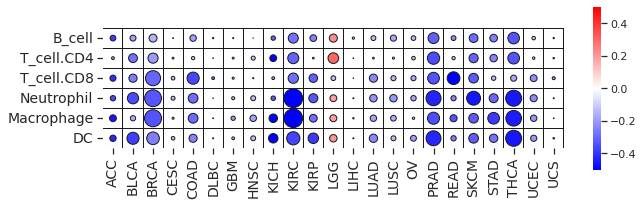

In [501]:
boPlot_infiltration(corr=timer_pak4_rho.T.astype(float), fdr=-np.log10(timer_pak4_p.T.astype(float)),
                    size_adjuster=10, fdr_threshold=0, vmin=-.5, vmax=.5,
                    path=poseidon_home + 'panels/Figure5/PAK4_timer.pdf')

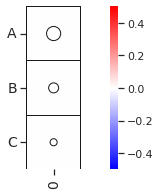

In [551]:
bo_legend = df(index=['A', 'B', 'C'], columns=['0'])
bo_legend.at['A', '0'] = 1e-20
bo_legend.at['B', '0'] = 1e-10
bo_legend.at['C', '0'] = 1e-5

boPlot_infiltration(corr=bo_legend,
                    fdr=-np.log10(bo_legend.astype(float)),
                    size_adjuster=10, fdr_threshold=0, vmin=-.5, vmax=.5,
                    path=poseidon_home + 'panels/Figure5/PAK4_timer_legend.pdf')

# GSEA on immune signature of PAK4 experiments

In [506]:
def case_gsea_compound_immune(drug_name, shift_result):
    # initialize
    gsea_result = {}
    
    # extract signature
    tmp_sig = shift_result[shift_result['cmap_name'] == drug_name]
    
    # get the GSEA
    for s in tmp_sig.index:
        p_rename = '__'.join(s.split(':'))
        rnk = pd.read_csv(gsea_home + shift_result.loc[s, 'cancer_type'] + '/trt_cp/' + p_rename + '.rnk', header=None, sep="\t")
        pre_res = gp.prerank(rnk=rnk, gene_sets=gsea_home + '/gene_sets/WolfEtAl_71_Symbols.gmt',
                             processes=20,
                             permutation_num=100,
                             outdir=None, seed=0, min_size=10, max_size=2000)
        gsea_result[s] = pre_res.res2d
        
    return gsea_result

In [507]:
case_pak4i_immune = case_gsea_compound_immune(drug_name='PF-03758309', shift_result=sub_compound)

In [512]:
# merge nes
pak4i_immune_nes = pd.concat([df(case_pak4i_immune[k]['nes']).rename(columns={'nes': k}) for k in case_pak4i_immune.keys()], axis=1)
pak4i_immune_nes['class'] = immunity_class['class']
pak4i_immune_by_class = pak4i_immune_nes.groupby('class').mean().T
pak4i_immune_by_class

class,Antigen Presentation,B cell,Cytokine,Cytotoxic T cell,DC cells,IFN Signaling,Leukocyte,Other,Proliferation,TAM
REP.A014_MCF7_24H:K17,-0.771331,1.288506,1.155196,1.681470,1.746864,0.807800,1.330030,1.040921,-2.173314,1.713594
REP.A014_MCF7_24H:K15,1.730517,1.425159,0.445912,1.553744,0.882786,-0.825873,1.818984,0.968946,-2.641986,1.916696
REP.B014_MCF7_24H:K13,1.544699,1.189290,0.839931,0.941126,-0.552988,0.802732,0.797906,0.860411,-2.355007,1.653773
REP.B014_MCF7_24H:K16,0.757013,-0.002841,0.713437,1.694388,1.181258,-1.620772,1.216264,0.853450,-2.158530,1.468298
REP.A014_MCF7_24H:K13,1.769474,1.344333,0.812308,1.399758,1.337802,1.797965,1.498410,1.356049,-2.496608,2.012617
...,...,...,...,...,...,...,...,...,...,...
REP.A014_A375_24H:K16,-1.656019,-0.911684,0.625850,0.250004,-1.017214,1.317282,0.821526,0.109950,-1.133926,-1.271872
REP.B014_A375_24H:K15,-1.848369,-1.203395,1.024377,0.416566,-1.032035,0.701469,0.661889,-0.409511,-1.068303,-1.158636
LJP009_A375_24H:D03,-2.106568,1.134459,1.096979,0.176010,0.737369,0.055153,-0.725566,0.678366,-2.786480,-1.069524
REP.A014_A375_24H:K17,-1.833409,-0.979492,-0.403681,-0.563584,-1.184770,1.518964,-0.659179,-0.346145,-1.067131,-1.462609


In [513]:
pak4i_immune_by_class['nearest_dose'] = sub_compound['nearest_dose']
pak4i_immune_by_class['cell_line'] = sub_compound['cell_line']

In [516]:
pak4i_immune_by_class.to_csv(poseidon_home + 'panels/Figure5/PAK4i_68immunity_nes.csv', sep=',')

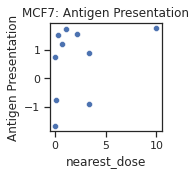

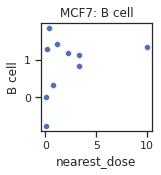

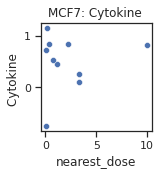

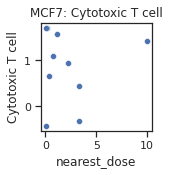

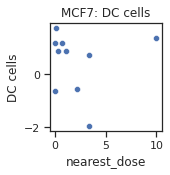

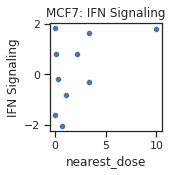

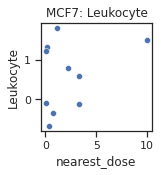

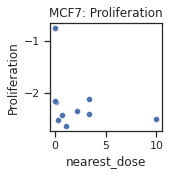

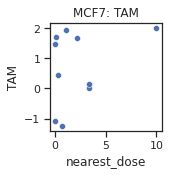

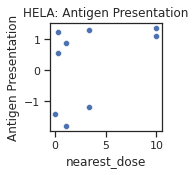

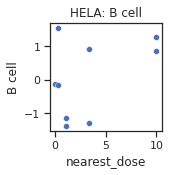

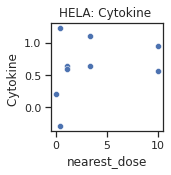

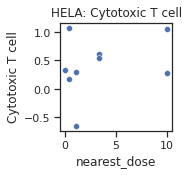

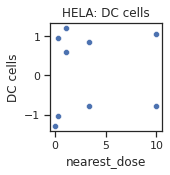

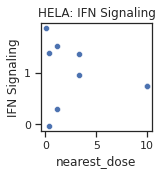

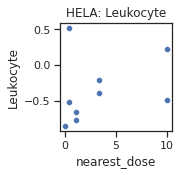

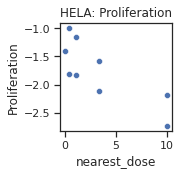

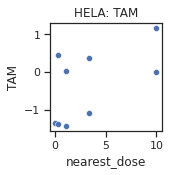

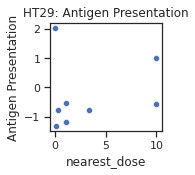

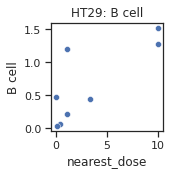

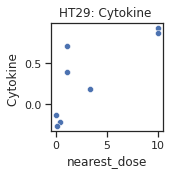

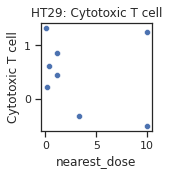

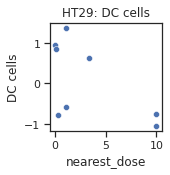

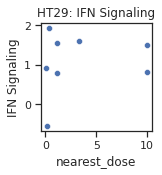

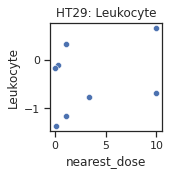

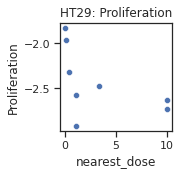

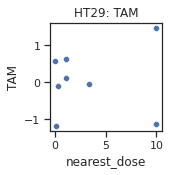

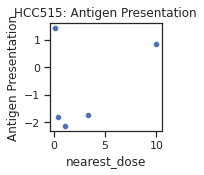

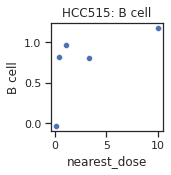

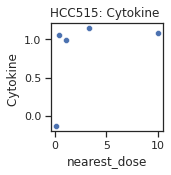

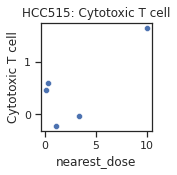

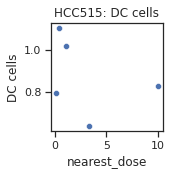

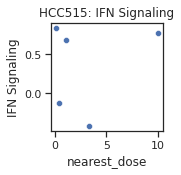

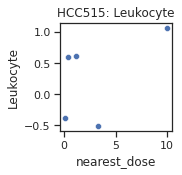

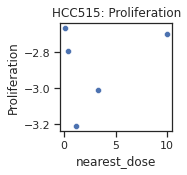

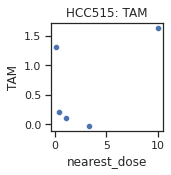

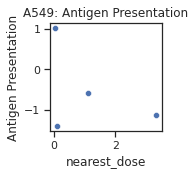

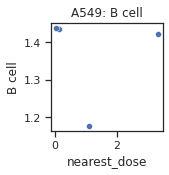

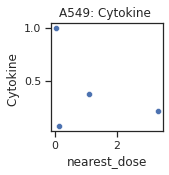

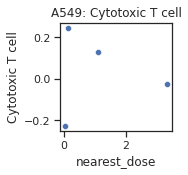

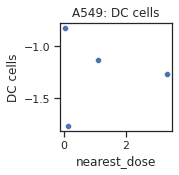

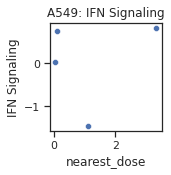

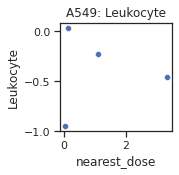

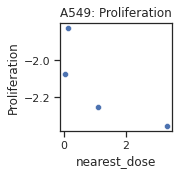

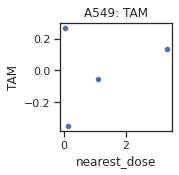

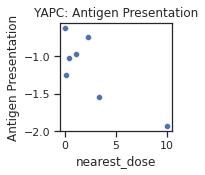

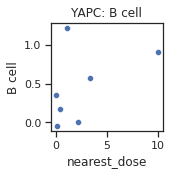

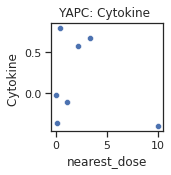

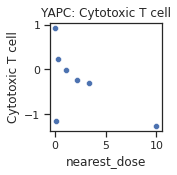

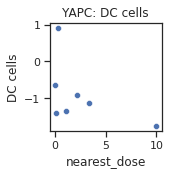

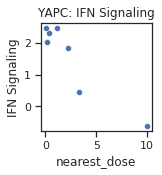

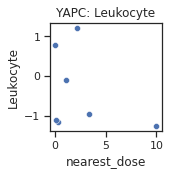

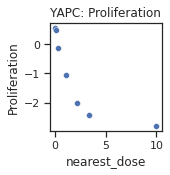

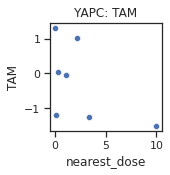

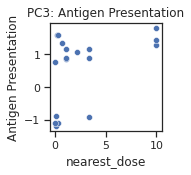

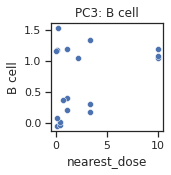

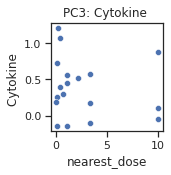

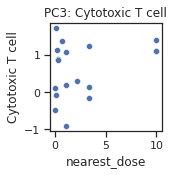

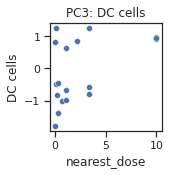

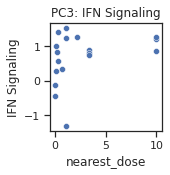

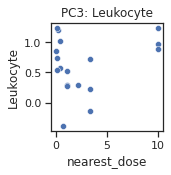

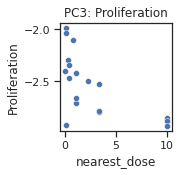

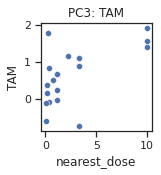

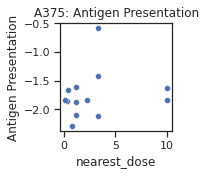

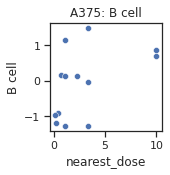

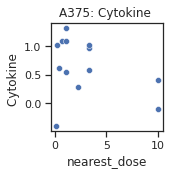

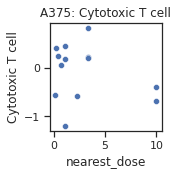

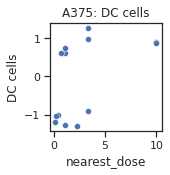

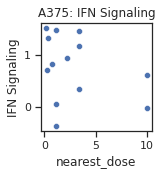

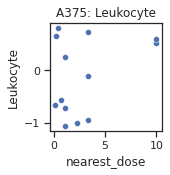

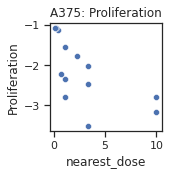

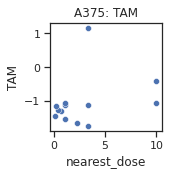

In [518]:
for cl in pak4i_immune_by_class['cell_line'].unique():
    tmp_cl = pak4i_immune_by_class[pak4i_immune_by_class['cell_line'] == cl]
    
    for c in tmp_cl.columns:
        if c not in ['nearest_dose', 'cell_line', 'Other']:
            plt.figure(figsize=(2, 2))
            sns.scatterplot(x='nearest_dose', y=c, data=tmp_cl)
            plt.title(cl + ': ' + c)
            plt.show()

In [554]:
corr_pak4i_immunity = df(index=pak4i_immune_by_class['cell_line'].unique())
p_pak4i_immunity = df(index=pak4i_immune_by_class['cell_line'].unique())
for cl in pak4i_immune_by_class['cell_line'].unique():
    tmp_cl = pak4i_immune_by_class[pak4i_immune_by_class['cell_line'] == cl]
    
    for c in tmp_cl.columns:
        if c not in ['nearest_dose', 'cell_line', 'Other']:
            corr_pak4i_immunity.at[cl, c], p_pak4i_immunity.at[cl, c] = stats.spearmanr(tmp_cl[c], tmp_cl['nearest_dose'])

In [555]:
corr_pak4i_immunity

,Antigen Presentation,B cell,Cytokine,Cytotoxic T cell,DC cells,IFN Signaling,Leukocyte,Proliferation,TAM
MCF7,0.522799,0.376901,-0.036474,-0.158055,-0.121581,0.115502,0.164134,-0.370822,0.279637
HELA,0.517023,0.135613,0.279701,0.135613,0.339032,-0.339032,0.440741,-0.762821,0.423790
HT29,0.168687,0.674748,0.843435,-0.385570,-0.554257,0.144589,0.277129,-0.771140,0.192785
HCC515,-0.100000,0.700000,0.800000,0.200000,-0.200000,-0.300000,0.400000,-0.300000,0.000000
A549,-0.400000,-0.800000,-0.400000,0.200000,-0.400000,0.400000,0.200000,-0.800000,-0.200000
YAPC,-0.642857,0.464286,-0.107143,-0.642857,-0.464286,-0.750000,-0.285714,-1.000000,-0.678571
PC3,0.472738,0.234811,-0.089353,0.268058,0.400009,0.446763,-0.125717,-0.681574,0.565208
A375,0.280968,0.436752,-0.189166,-0.141875,0.609227,-0.369987,0.025037,-0.803957,0.378333


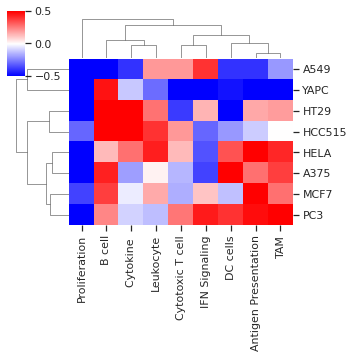

In [556]:
sns.clustermap(corr_pak4i_immunity,
               figsize=(5, 5), vmin=-.5, vmax=.5,
               method='ward', cmap='bwr')

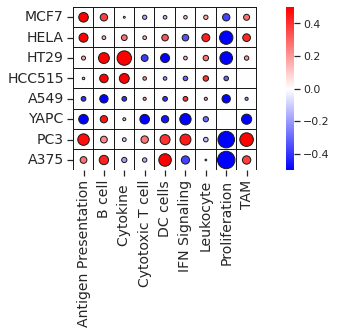

In [557]:
boPlot_infiltration(corr=corr_pak4i_immunity.astype(float), fdr=-np.log10(p_pak4i_immunity.astype(float)),
                    size_adjuster=100, fdr_threshold=0, vmin=-.5, vmax=.5,
                    path=poseidon_home + 'panels/Figure5/PAKi_68immunity.pdf')

In [558]:
pak4i_ave_shift = sub_compound[sub_compound['cmap_name'] == 'PF-03758309'].groupby('cell_line').mean().sort_values(by='shift_ability', ascending=False)

In [559]:
pak4i_ave_shift

,NREC_profile,REC_profile,nearest_dose,shift_ability
cell_line,,,,
PC3,-0.385401,0.293592,2.646389,0.678993
HT29,-0.381337,0.274595,3.260625,0.655932
A375,-0.341687,0.264750,2.848077,0.606437
HCC515,-0.338746,0.251501,2.986000,0.590247
YAPC,-0.312262,0.149346,2.456429,0.461608
MCF7,-0.292192,0.123143,2.134500,0.415335
HELA,-0.239279,0.022596,3.295556,0.261876
A549,-0.254378,-0.023427,1.150000,0.230951


In [565]:
apc_order = corr_pak4i_immunity.sort_values(by='Antigen Presentation', ascending=False)

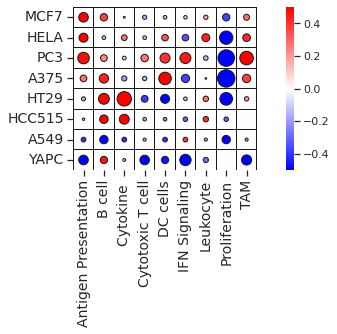

In [566]:
boPlot_infiltration(corr=corr_pak4i_immunity.loc[apc_order.index, :].astype(float),
                    fdr=-np.log10(p_pak4i_immunity.loc[apc_order.index, :].astype(float)),
                    size_adjuster=100, fdr_threshold=0, vmin=-.5, vmax=.5,
                    path=poseidon_home + 'panels/Figure5/PAKi_68immunity.pdf')

In [568]:
p_pak4i_immunity

,Antigen Presentation,B cell,Cytokine,Cytotoxic T cell,DC cells,IFN Signaling,Leukocyte,Proliferation,TAM
MCF7,0.121027,0.283003,0.920318,0.662762,0.737938,0.750683,0.650473,0.291468,0.433926
HELA,0.154056,0.727931,0.466050,0.727931,0.372112,0.372112,0.235069,0.016814,0.255659
HT29,0.689661,0.066402,0.008503,0.345511,0.153988,0.732651,0.506375,0.025059,0.647384
HCC515,0.872889,0.188120,0.104088,0.747060,0.747060,0.623838,0.504632,0.623838,1.000000
A549,0.600000,0.200000,0.600000,0.800000,0.600000,0.600000,0.800000,0.200000,0.800000
YAPC,0.119392,0.293934,0.819151,0.119392,0.293934,0.052181,0.534509,0.000000,0.093750
PC3,0.047568,0.348294,0.724402,0.282166,0.100017,0.063069,0.619146,0.001840,0.014513
A375,0.352426,0.135644,0.535946,0.643834,0.027090,0.213374,0.935293,0.000926,0.202422


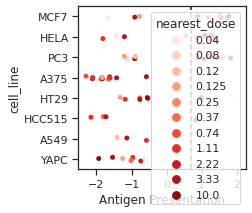

In [567]:
plt.figure(figsize=(3, 3))
sns.stripplot(x='Antigen Presentation', y='cell_line', hue='nearest_dose',
              data=pak4i_immune_by_class,
              order=apc_order.index, palette='Reds')
plt.axvline(x=.7, ls='--', c='k')
fig = plt.gcf()
fig.savefig(poseidon_home + 'panels/Figure5/PAKi_cell_line_apc.pdf', transparent=True)

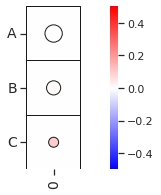

In [563]:
bo_legend = df(index=['A', 'B', 'C'], columns=['0'])
bo_legend.at['A', '0'] = 1e-3
bo_legend.at['B', '0'] = 1e-2
bo_legend.at['C', '0'] = 1e-1

boPlot_infiltration(corr=bo_legend,
                    fdr=-np.log10(bo_legend.astype(float)),
                    size_adjuster=100, fdr_threshold=0, vmin=-.5, vmax=.5,
                    path=poseidon_home + 'panels/Figure5/PAK4i_dosage_legend.pdf')

In [569]:
timer_estimation.shape

(10009, 6)